Author : Gervasius Russell

Topic : Breast Cancer Detection

Sub-Topic : invasive ductal carcinoma detection using Deep Learning

# **Project: Automated Detection of Invasive Ductal Carcinoma (IDC) using Deep Learning**

## 1. Introduction & Context
Breast cancer is one of the most common forms of cancer worldwide, and **Invasive Ductal Carcinoma (IDC)** is its most frequent subtype. Accurately identifying regions of IDC in breast tissue is a critical task for pathologists. To assign an aggressiveness grade to a breast cancer specimen, pathologists must visually inspect whole-mount tissue slides to locate and delineate the specific regions containing IDC.

This manual process is time-consuming, labor-intensive, and subject to inter-observer variability. Automating the detection of IDC regions can significantly speed up the workflow, reduce error rates, and act as a crucial "second opinion" tool in clinical settings.

## 2. Project Objective
The primary goal of this project is to build a **Deep Learning model** capable of classifying microscopic tissue images into two categories:
* **IDC Negative (0):** Benign or healthy tissue.
* **IDC Positive (1):** Tissue containing Invasive Ductal Carcinoma.

By successfully classifying these small image patches, the system can effectively "map" whole tissue slides to highlight cancerous regions for pathologists.

## 3. Dataset Overview
This project utilizes the **Breast Histopathology Images** dataset (originally curated by Paul Timothy Mooney on Kaggle).

* **Source Data:** 162 whole-mount slide images of Breast Cancer specimens scanned at 40x magnification.
* **Input Format:** The slides were sliced into small patches to make them processable by machine learning algorithms.
* **Total Images:** 277,524 patches.
* **Image Dimensions:** $50 \times 50$ pixels.
* **File Naming Convention:** `u_xX_yY_classC.png`
    * `u`: Patient ID (e.g., `10253_idx5`)
    * `x`/`y`: Coordinates of the crop.
    * `classC`: The label (`0` or `1`).

### Class Distribution
The dataset is imbalanced, with significantly more non-cancerous examples than cancerous ones:
* **IDC Negative (0):** 198,738 images (~71.6%)
* **IDC Positive (1):** 78,786 images (~28.4%)

## 4. Methodology
The project follows a standard Data Science lifecycle:

1.  **Data Loading & EDA:** Parsing file paths, visualizing random samples, and confirming class distribution.
2.  **Preprocessing:**
    * Resizing (if necessary, though $50 \times 50$ is standard).
    * Normalization (scaling pixel values to 0-1 range).
    * Handling Class Imbalance (undersampling, oversampling, or class weights).
3.  **Model Architecture:**
    * Implementation of a Convolutional Neural Network (CNN).
    * Exploration of Custom CNNs vs. Transfer Learning.
4.  **Training:** Utilizing binary cross-entropy loss and Adam optimization.
5.  **Evaluation:**
    * Metrics: Accuracy, Precision, Recall (Sensitivity), F1-Score, and ROC-AUC.
    * **Focus:** High Recall is prioritized to minimize False Negatives (missing a cancer case is worse than a false alarm).

## 5. Expected Outcome
A robust deep learning model that can take a $50 \times 50$ image patch of breast tissue and predict the probability of IDC presence with high sensitivity.

---

# Data Loading & Exploration

Goal: We need to find all the image files, organize their file paths into a DataFrame, and verify the class imbalance (Cancer vs. Healthy).

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

Total images found: 277524

--- Class Distribution ---
label
0    198738
1     78786
Name: count, dtype: int64

Percentage of Non-Cancerous (0): 71.61%
Percentage of Cancerous (1):     28.39%

--- Visualizing Samples ---


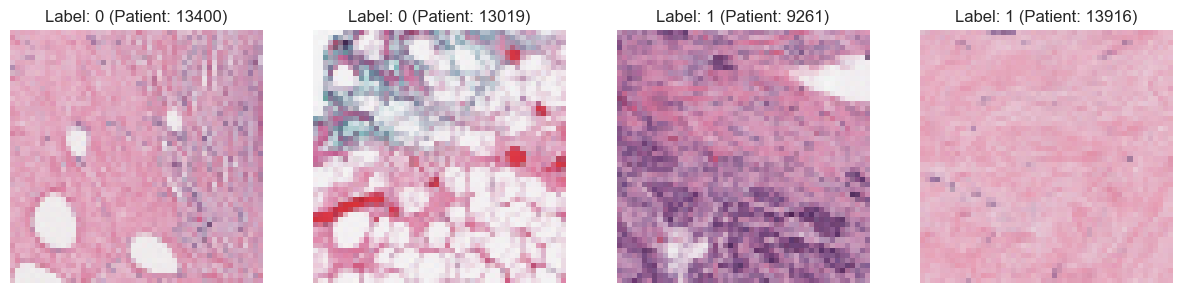

In [3]:
# ==========================================
# CONFIGURATION
# ==========================================

# Set the dataset path
DATASET_PATH = "C:/Users/gerva/OneDrive/Documents/BINUS/SEM 5/BELG/breast-histopathology-images/IDC_regular_ps50_idx5"


# 1. Load all image paths
# The dataset structure: path/to/data/patient_id/class_label/image.png
image_paths = glob(os.path.join(DATASET_PATH, '**', '*.png'), recursive=True)

if len(image_paths) == 0:
    print("ERROR: No images found.")
else:
    print(f"Total images found: {len(image_paths)}")

    # 2. Create a DataFrame to manage the data
    # We extract the label from the folder name: '0' = Negative (Benign), '1' = Positive (Malignant)
    data = []
    for path in image_paths:
        # Split path to get metadata
        parts = path.split(os.sep)
        label = parts[-2]     # The folder name (0 or 1)
        patient_id = parts[-3] # The patient ID folder
        data.append({'path': path, 'patient_id': patient_id, 'label': label})

    df = pd.DataFrame(data)

    # 3. Analyze the Class Distribution
    print("\n--- Class Distribution ---")
    print(df['label'].value_counts())
    
    # Calculate percentage
    counts = df['label'].value_counts()
    total = len(df)
    print(f"\nPercentage of Non-Cancerous (0): {counts['0'] / total * 100:.2f}%")
    print(f"Percentage of Cancerous (1):     {counts['1'] / total * 100:.2f}%")

    # 4. Visualize Sample Images
    print("\n--- Visualizing Samples ---")
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    
    # Get 2 random images from class 0 and 2 from class 1
    # We use try/except in case a class is missing in a small test run
    try:
        sample_0 = df[df['label'] == '0'].sample(2)
        sample_1 = df[df['label'] == '1'].sample(2)
        samples = pd.concat([sample_0, sample_1])

        for i, (idx, row) in enumerate(samples.iterrows()):
            img = mpimg.imread(row['path'])
            axes[i].imshow(img)
            axes[i].set_title(f"Label: {row['label']} (Patient: {row['patient_id']})")
            axes[i].axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not visualize samples: {e}")

- Data Integrity: We have the full dataset (277k images). The loading process worked perfectly.

- The Imbalance Problem:

    - 72% Healthy vs 28% Cancer.

    - Why this matters: If the model gets lazy and predicts "Healthy" for every single image, it will still get 72% accuracy. This is a "dummy model." We need our accuracy to be much higher than 72%, and we must pay attention to Recall (catching the cancer cases).

### Patient Data Distribution

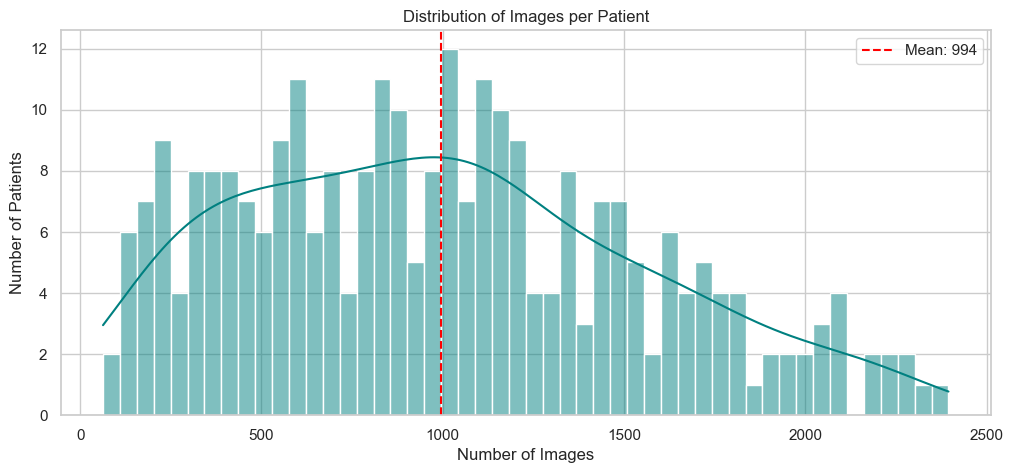

Max images for one patient: 2395
Min images for one patient: 63


In [7]:
sns.set_style("whitegrid")

patient_counts = df.groupby('patient_id').size()

plt.figure(figsize=(12, 5))
sns.histplot(patient_counts, bins=50, kde=True, color='teal')
plt.title('Distribution of Images per Patient')
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.axvline(patient_counts.mean(), color='red', linestyle='--', label=f'Mean: {int(patient_counts.mean())}')
plt.legend()
plt.show()

print(f"Max images for one patient: {patient_counts.max()}")
print(f"Min images for one patient: {patient_counts.min()}")

As we can see from the plot above there is a big imbalance between patients where one can have 2,395 images and on the other side only 63 images

Why this matters: If we treat all images equally, the model will spend 40x more time learning about "Patient {2395}" than "Patient {63}." The model risks overfitting to the specific biology (e.g., staining color, tissue density) of the "heavy" patients rather than learning general cancer features.

### Pixel Intensity Analysis (Brightness/Color)

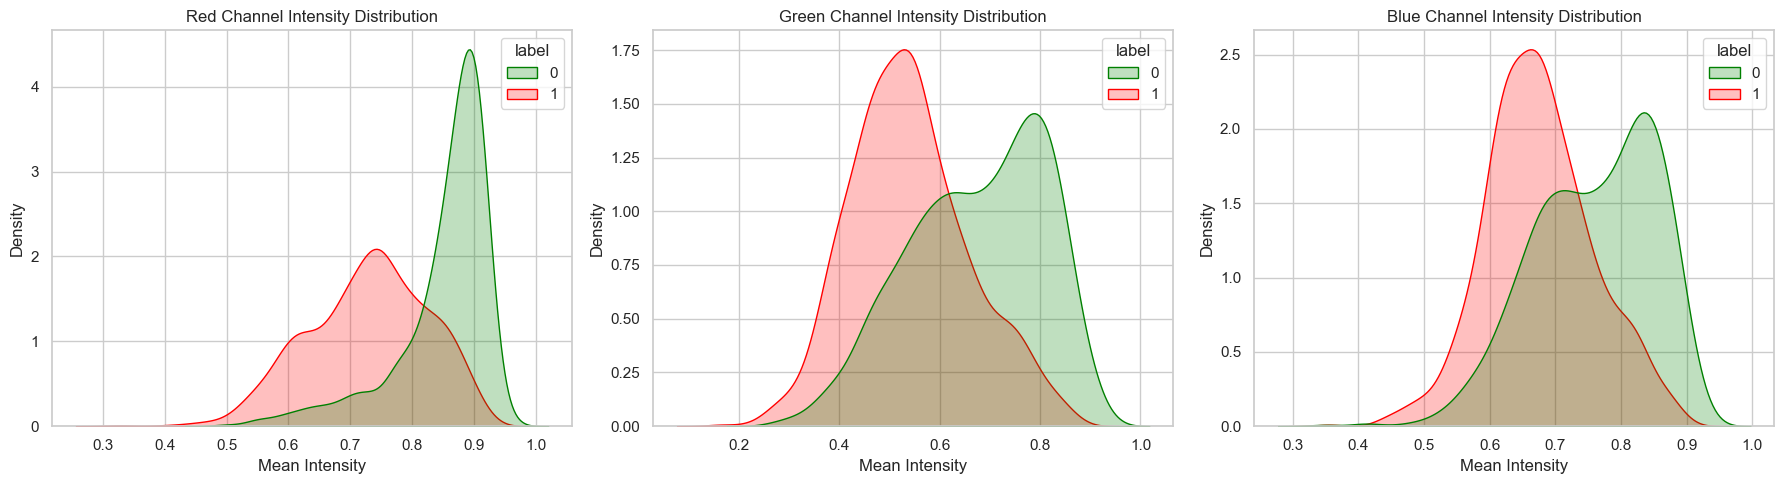

In [8]:
# We take a random sample because processing 277k images takes too long
sample_df = df.groupby('label').apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)

def get_pixel_stats(path):
    img = mpimg.imread(path)
    # img is usually (50, 50, 3) normalized 0-1 or 0-255
    # We take the mean of the Red, Green, and Blue channels separately
    return img[:,:,0].mean(), img[:,:,1].mean(), img[:,:,2].mean()

# Apply to the sample
pixel_stats = sample_df['path'].apply(lambda x: pd.Series(get_pixel_stats(x)))
sample_df[['R_mean', 'G_mean', 'B_mean']] = pixel_stats

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['Red', 'Green', 'Blue']

for i, col in enumerate(['R_mean', 'G_mean', 'B_mean']):
    sns.kdeplot(data=sample_df, x=col, hue='label', fill=True, ax=axes[i], palette=['green', 'red'])
    axes[i].set_title(f'{colors[i]} Channel Intensity Distribution')
    axes[i].set_xlabel('Mean Intensity')

plt.tight_layout()
plt.show()

1. The "Left-Shift" Phenomenon (Darkness)
- Observation: In all three graphs (Red, Green, and Blue channels), the Red area (Cancer/Class 1) is consistently shifted to the left compared to the Green area (Healthy/Class 0).

- Meaning: In RGB image data, a value of 1.0 is white/bright, and 0.0 is black/dark.

- Conclusion: Cancerous tissue is significantly darker than healthy tissue. The peak of the "Healthy" distribution is usually around 0.8-0.9 (very bright/pink), while the "Cancer" distribution peaks lower, around 0.5-0.7.

2. The Biological Reason (Why is it darker?)
- This statistical finding matches the biology of H&E (Hematoxylin and Eosin) staining perfectly:

- Healthy Tissue: Contains a lot of fat cells, cytoplasm, and connective tissue. These structures do not absorb the dark purple dye (Hematoxylin) very well. They appear light pink or white. (High Intensity)

- Cancer Tissue: Cancer cells divide uncontrollably. This results in Hypercellularity (too many cells packed together) and Nuclear Atypia (the nuclei get larger and darker). Nuclei absorb the Hematoxylin dye aggressively, turning deep purple/blue. (Low Intensity)

### Average Cell Image

Class 0: Averaged 500 images.
Class 1: Averaged 500 images.


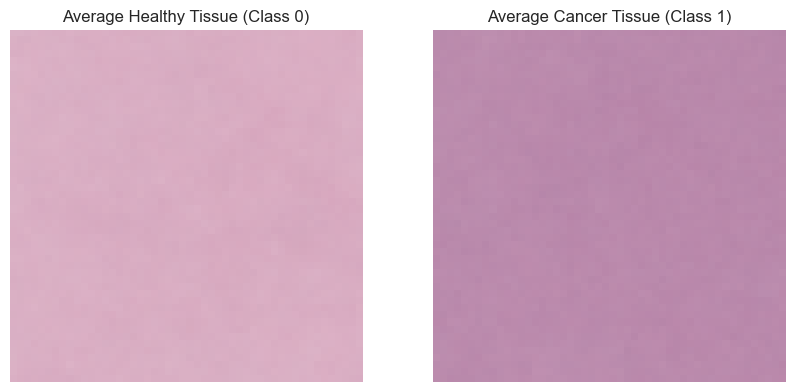

In [9]:
def create_average_image(label, n_images=500):
    # Get more paths than needed (e.g. 300) in case we have to skip some
    paths = df[df['label'] == label]['path'].sample(n_images + 100, random_state=42).values
    
    valid_images = []
    for p in paths:
        try:
            img = mpimg.imread(p)
            # Only accept images that are 50x50x3 because some images is in different size
            if img.shape == (50, 50, 3):
                valid_images.append(img)
        except:
            continue
            
        # Stop once we have enough
        if len(valid_images) >= n_images:
            break
    
    print(f"Class {label}: Averaged {len(valid_images)} images.")
    # Stack them and calculate mean
    return np.mean(valid_images, axis=0)

avg_0 = create_average_image('0') # Healthy
avg_1 = create_average_image('1') # Cancer

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(avg_0)
ax[0].set_title("Average Healthy Tissue (Class 0)")
ax[0].axis('off')

ax[1].imshow(avg_1)
ax[1].set_title("Average Cancer Tissue (Class 1)")
ax[1].axis('off')

plt.show()


- Left (Healthy): Light pink. This represents tissue with lower cell density and more connective tissue (stroma/fat), which doesn't hold the dark dye.

- Right (Cancer): Distinctly darker and more purple. This is caused by Hypercellularity—cancer cells crowding together with enlarged nuclei that absorb the purple dye (Hematoxylin).

### Binary target visualisation per tissue slice

reconstruct the "Whole Image" view by plotting the patches according to their X and Y coordinates.

Blue regions: Healthy tissue.

Red regions: Cancerous tissue (IDC).

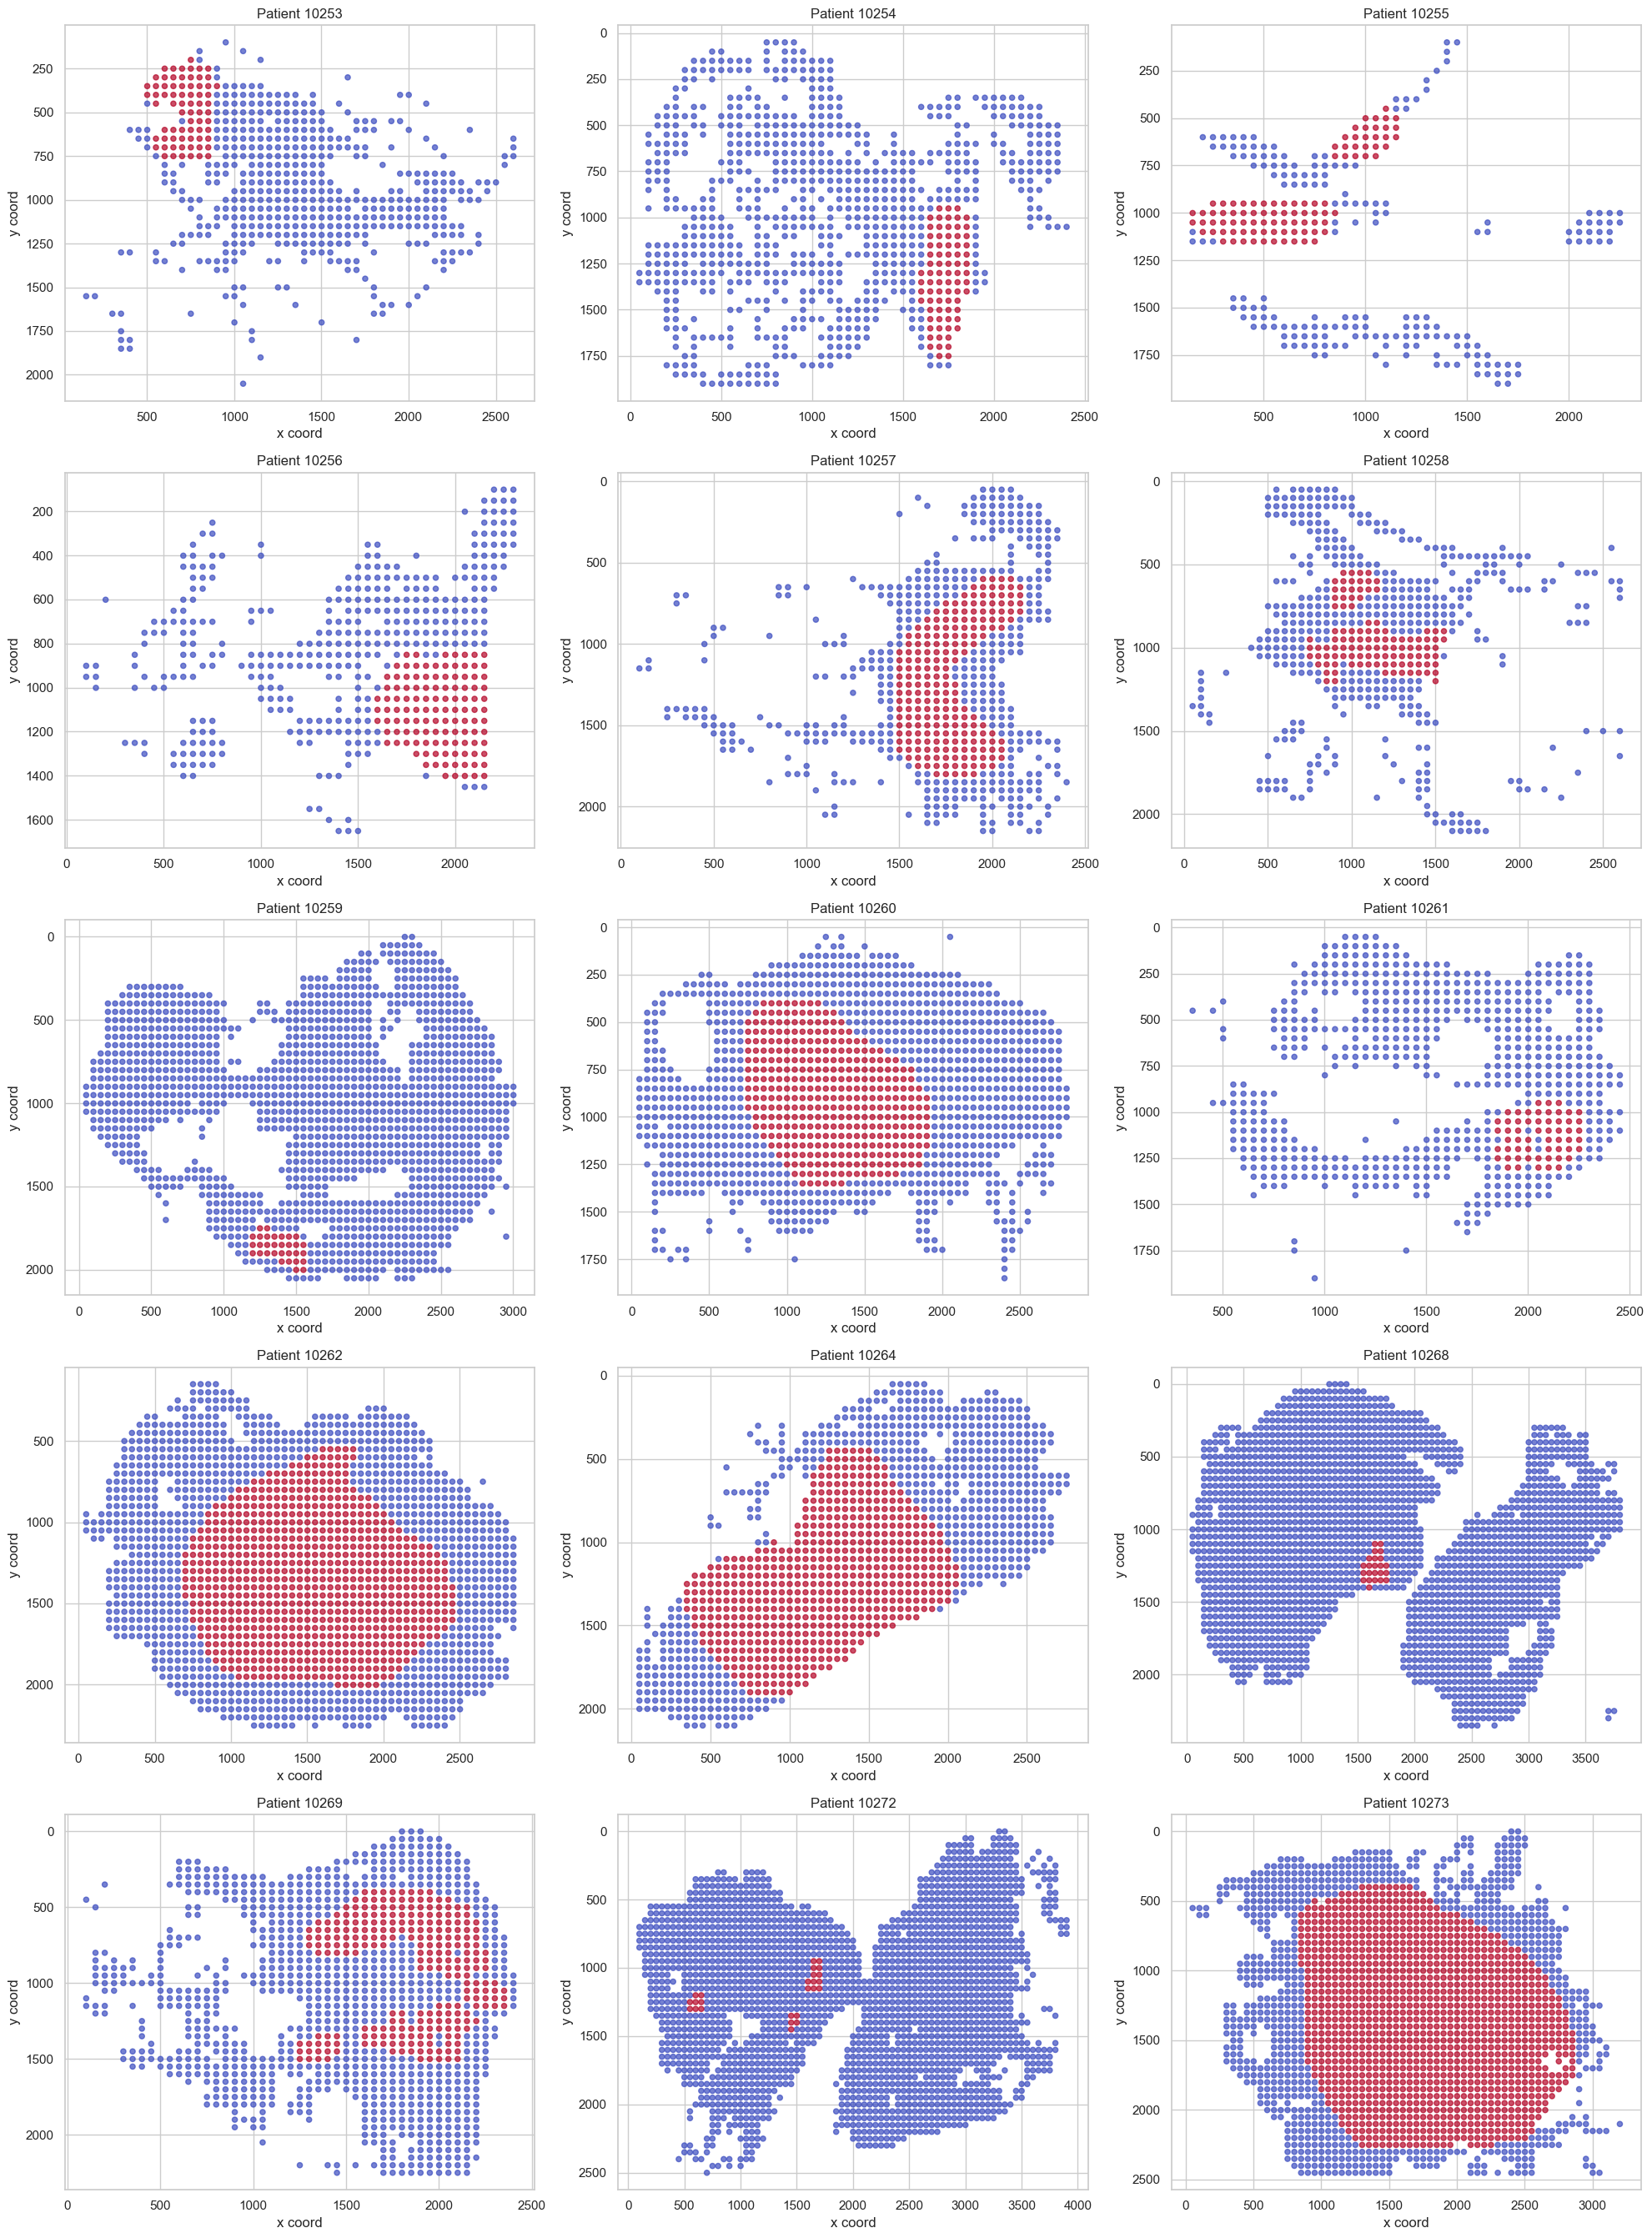

In [10]:

# 1. PRE-PROCESSING: Extract X and Y from filenames

def extract_metadata(path):
    # Filename format ex: 10253_idx5_x1351_y1101_class0.png
    filename = os.path.basename(path)
    parts = filename.split('_')
    
    # Extract X and Y (they look like 'x1351' and 'y1101')
    # We assume the format is consistent as per dataset description
    try:
        x_coord = int(parts[2][1:]) # Skip the 'x'
        y_coord = int(parts[3][1:]) # Skip the 'y'
    except:
        x_coord, y_coord = 0, 0 # Fallback for weird filenames
        
    return x_coord, y_coord

# Apply extraction to the main dataframe 'df'
df[['x', 'y']] = df['path'].apply(lambda p: pd.Series(extract_metadata(p)))

# Create a numeric 'target' column (int version of label) for the color map
df['target'] = df['label'].astype(int)

# 2. VISUALIZATION (Adapted from your snippet)

patient_ids = df.patient_id.unique()

fig, ax = plt.subplots(5, 3, figsize=(20, 27))

for n in range(5):
    for m in range(3):
        # Calculate index to get different patients
        idx = m + 3*n
        if idx >= len(patient_ids): break
        
        patient_id = patient_ids[idx]
        
        # Get dataframe for this specific patient
        example_df = df[df['patient_id'] == patient_id]
        
        # Scatter plot: X vs Y, colored by Cancer (Red) or Healthy (Blue)
        ax[n,m].scatter(example_df.x.values, 
                        example_df.y.values, 
                        c=example_df.target.values, 
                        cmap="coolwarm", 
                        s=20, 
                        alpha=0.7) # Added alpha to see overlap better
        
        ax[n,m].set_title("Patient " + patient_id)
        ax[n,m].set_xlabel("x coord") # Swapped label to match standard (x is horizontal)
        ax[n,m].set_ylabel("y coord")
        ax[n,m].invert_yaxis() # Images usually have (0,0) at top-left, so we invert Y

plt.tight_layout()
plt.show()

Cancer is "Clustered" not Random

- Observation: Look at Patient 10273 (Bottom Right) or Patient 10262 (Middle Left). The red dots (Cancer) form massive, solid islands. They are not sprinkled randomly like salt.

- Biological Meaning: This confirms the biological nature of Invasive Ductal Carcinoma. It grows as a solid tumor mass invading the tissue.

- AI Implication: This is good news for the model. Since cancer patches are grouped together, they likely share similar visual features (texture/color) that the model can learn.

Patient Variability ("Easy" vs "Hard" Patients)

- Patient 10268 (Middle Right): Has very small, isolated regions of cancer. This patient is "hard" to diagnose because the cancer is subtle.

- Patient 10273 (Bottom Right): Has a massive tumor. This is "easy" to detect.

- Conclusion: the model needs to be robust enough to catch the small, subtle cases (10268) without getting overwhelmed by the massive ones.

### Whole Slide Reconstruction

Reconstructed Tissue on the left

the Cancer Masked on the right.

Stitching Patient 10253 (Canvas: 2651x2101)...
Stitching Patient 10254 (Canvas: 2451x1951)...
Stitching Patient 10255 (Canvas: 2301x1951)...
Stitching Patient 10256 (Canvas: 2351x1701)...
Stitching Patient 10257 (Canvas: 2451x2201)...


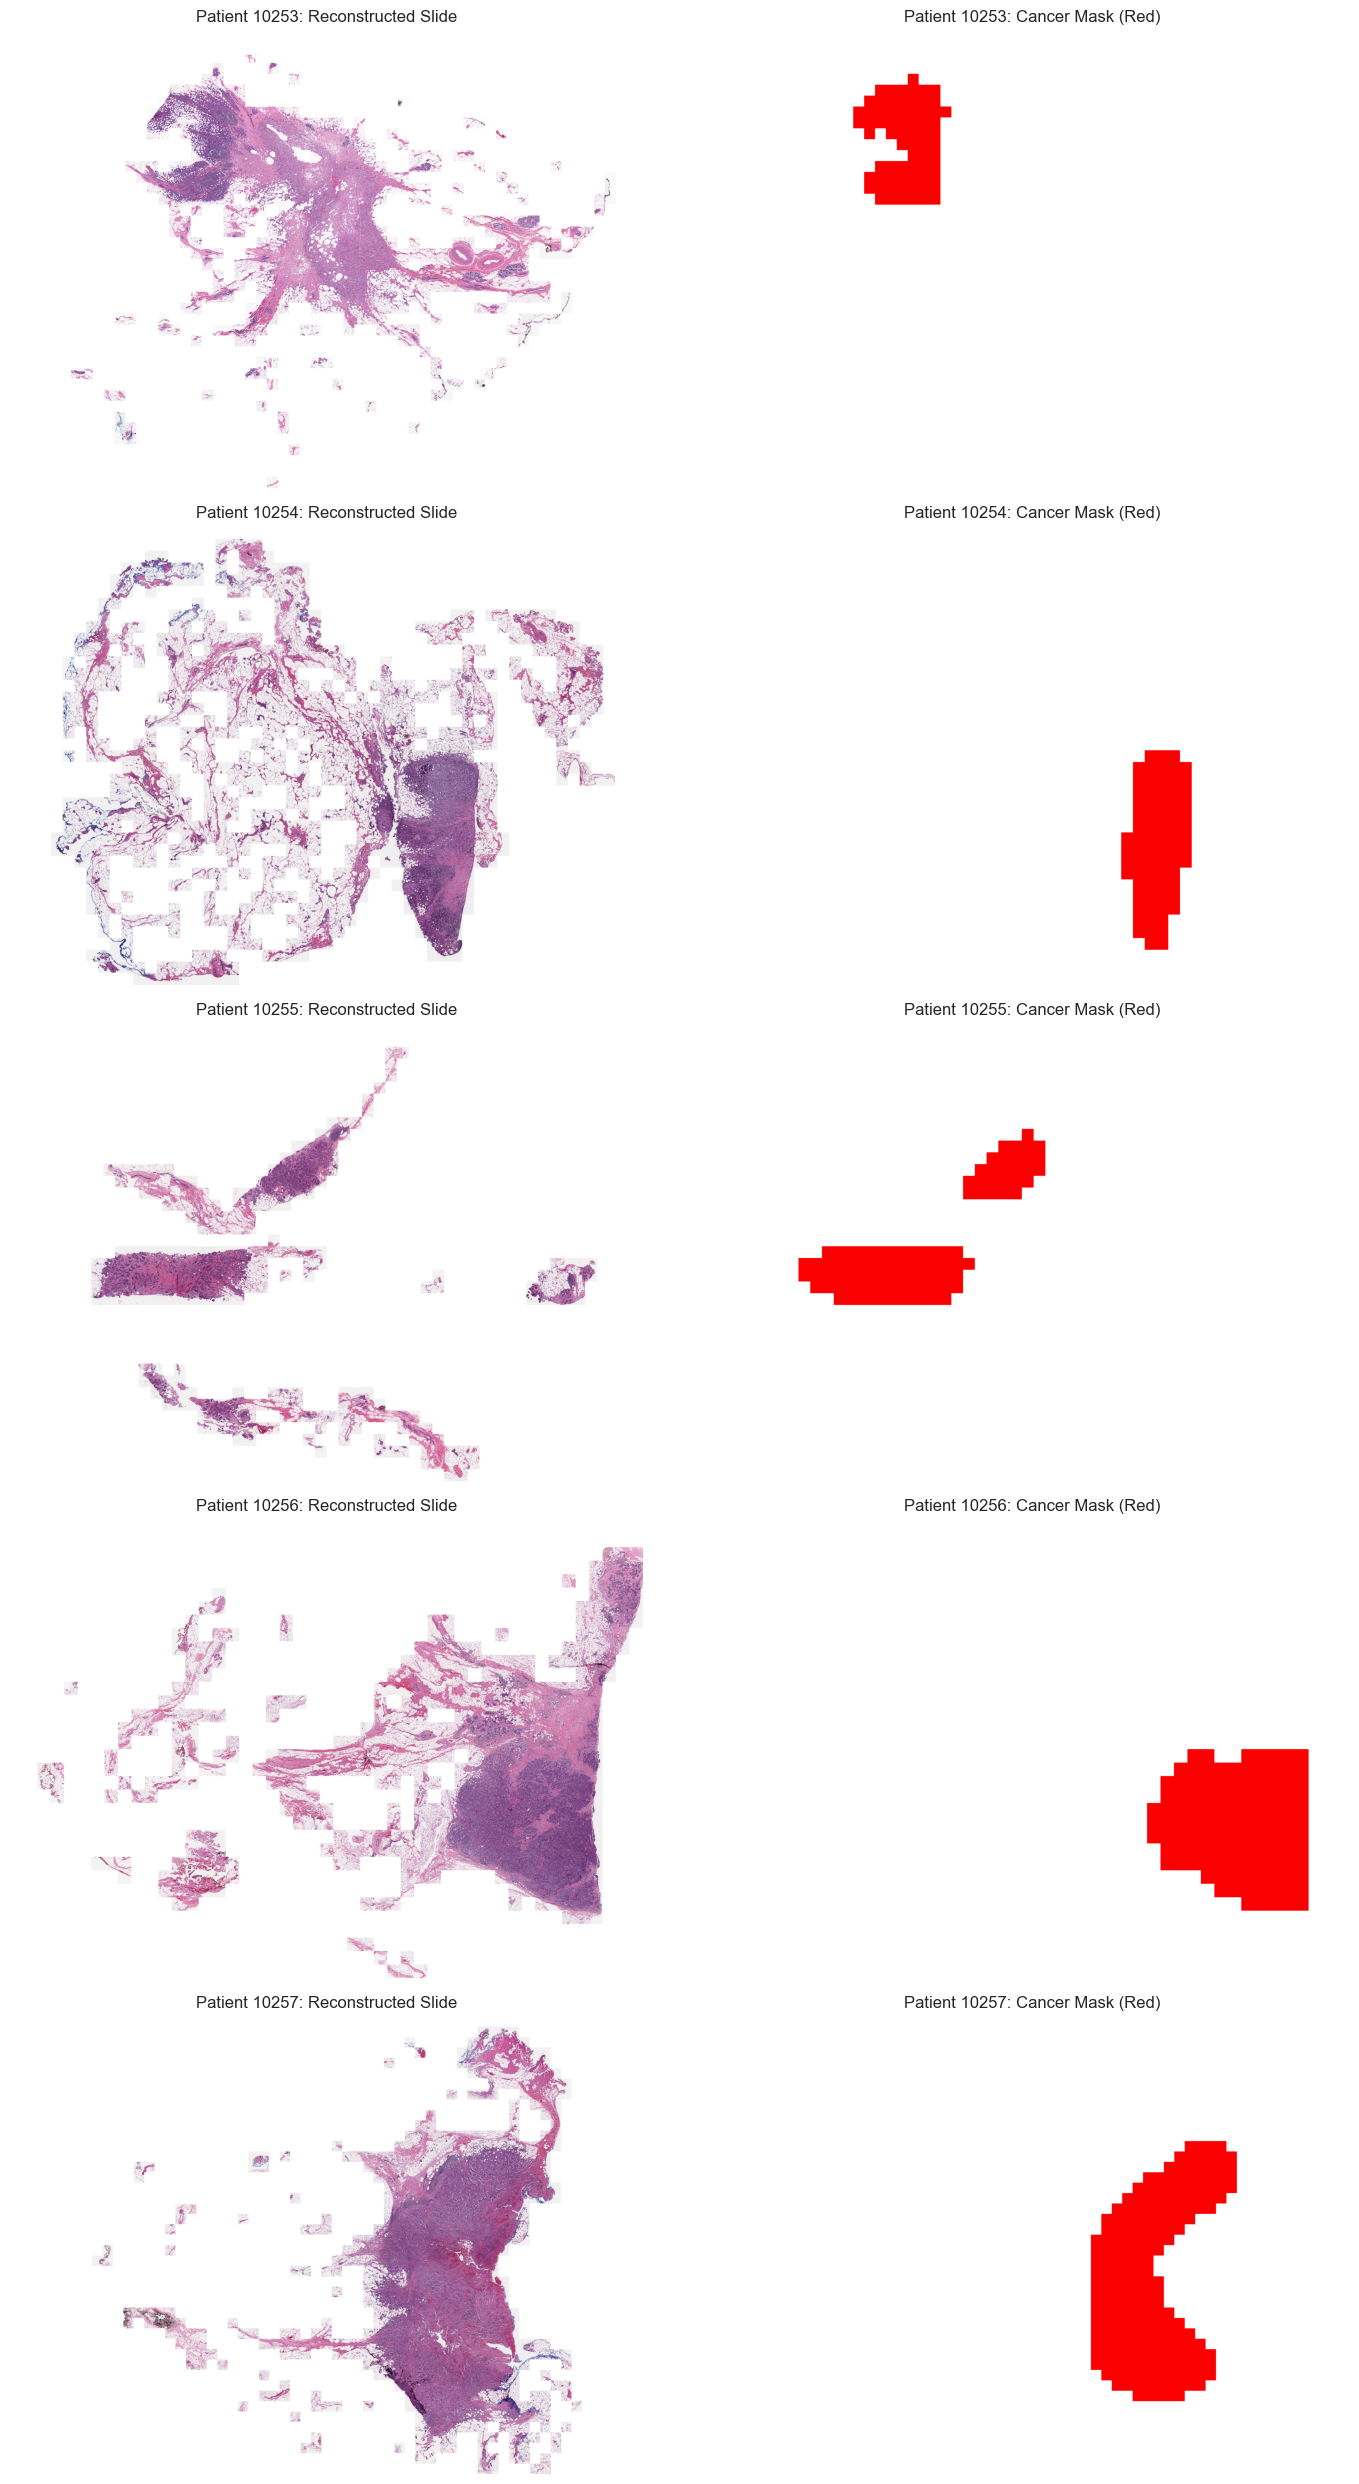

In [11]:
# Helper function to filter our main dataframe
def get_patient_dataframe(patient_id):
    return df[df['patient_id'] == patient_id]

def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    
    # Calculate the canvas size
    # We add 50 because x,y is the top-left corner of a 50x50 patch
    max_x = example_df.x.max() + 50
    max_y = example_df.y.max() + 50
    
    # Create blank white canvases (Height, Width, Channels)
    grid = 255 * np.ones(shape=(max_y, max_x, 3), dtype=np.uint8)
    mask = 255 * np.ones(shape=(max_y, max_x, 3), dtype=np.uint8)
    
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    
    # Placeholder for probability mask (not used in EDA step)
    mask_proba = np.zeros(shape=(max_y, max_x, 1), dtype=float)
    
    broken_patches = []
    
    print(f"Stitching Patient {patient_id} (Canvas: {max_x}x{max_y})...")
    
    for _, row in example_df.iterrows():
        try:
            # Load image
            image = mpimg.imread(row['path'])
            
            # FIX: Convert 0-1 float images to 0-255 uint8 if necessary
            if image.dtype == np.float32 or image.dtype == np.float64:
                image = (image * 255).astype(np.uint8)
            
            target = int(row['target'])
            x_coord = int(row['x'])
            y_coord = int(row['y'])
            
            # Define the patch area
            y_start = y_coord
            y_end = y_start + 50
            x_start = x_coord
            x_end = x_start + 50

            # Paste image into grid
            if y_end <= max_y and x_end <= max_x:
                grid[y_start:y_end, x_start:x_end] = image
                
                # Create the Ground Truth Mask (Red = Cancer)
                if target == 1:
                    mask[y_start:y_end, x_start:x_end, 0] = 250 # R
                    mask[y_start:y_end, x_start:x_end, 1] = 0   # G
                    mask[y_start:y_end, x_start:x_end, 2] = 0   # B
                
                # (Optional) If we had predictions, we would fill mask_proba here
                
        except Exception as e:
            broken_patches.append(row['path'])
    
    return grid, mask, broken_patches


# Select 5 random patients from the dataframe
target_patients = df['patient_id'].unique()[:5]

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for i, pid in enumerate(target_patients):
    # Run the stitching function
    grid_img, mask_img, _ = visualise_breast_tissue(pid)
    
    # Plot 1: The Actual Tissue
    axes[i, 0].imshow(grid_img)
    axes[i, 0].set_title(f"Patient {pid}: Reconstructed Slide")
    axes[i, 0].axis('off')
    
    # Plot 2: The Cancer Mask
    axes[i, 1].imshow(mask_img)
    axes[i, 1].set_title(f"Patient {pid}: Cancer Mask (Red)")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

As we can see from all of the patients. The shape of the "Dark Purple" tissue on the left matches the "Red Mask" on the right almost perfectly.

The model has a very strong visual signal to learn from. It doesn't need to guess; the cancer is visibly different (darker/denser).

### Patient Severity Analysis

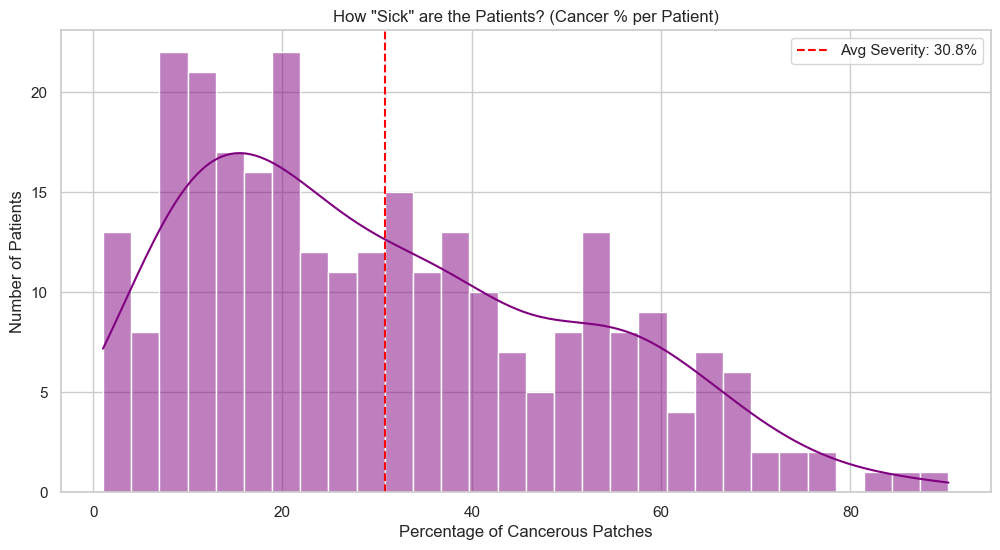

Most severe patient has 90.4% cancer patches.
Least severe patient has 1.0% cancer patches.


In [12]:
# Calculate the percentage of cancer images for each patient
patient_stats = df.groupby('patient_id')['target'].mean() * 100
patient_stats = patient_stats.reset_index()
patient_stats.columns = ['patient_id', 'cancer_percentage']

plt.figure(figsize=(12, 6))
sns.histplot(patient_stats['cancer_percentage'], bins=30, kde=True, color='purple')
plt.title('How "Sick" are the Patients? (Cancer % per Patient)')
plt.xlabel('Percentage of Cancerous Patches')
plt.ylabel('Number of Patients')
plt.axvline(patient_stats['cancer_percentage'].mean(), color='red', linestyle='--', label=f"Avg Severity: {patient_stats['cancer_percentage'].mean():.1f}%")
plt.legend()
plt.show()

print("Most severe patient has {:.1f}% cancer patches.".format(patient_stats['cancer_percentage'].max()))
print("Least severe patient has {:.1f}% cancer patches.".format(patient_stats['cancer_percentage'].min()))

- There's outliers that has 90% cancer tissue and only 1% cancerous tissue

- Most patients fall in the 10% - 35% range. This is good; it means most slides are a healthy mix of normal tissue and tumor, giving the model good contrast to learn from.

### Image Brightness Distribution & Outliers

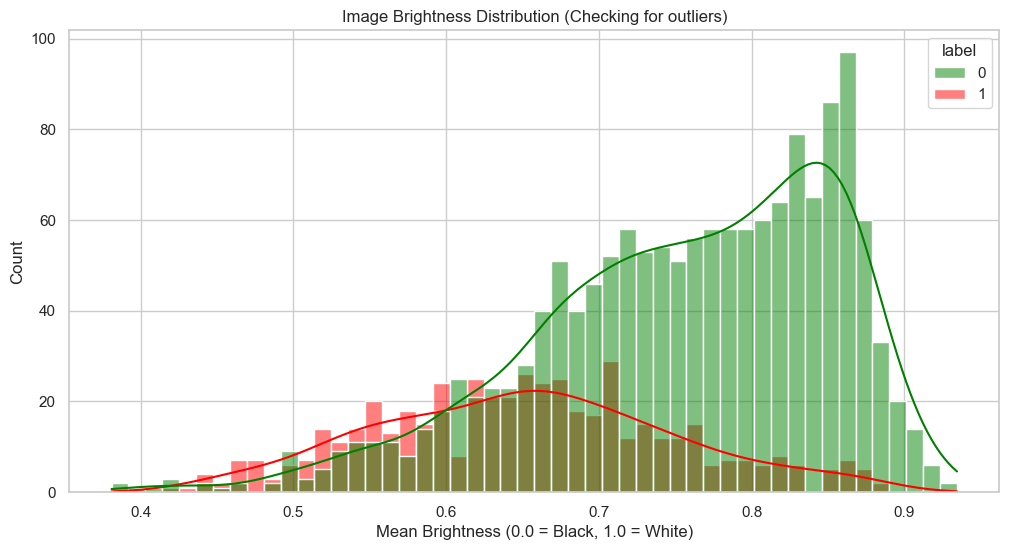

Potential 'Black' images (artifacts): 0
Potential 'White' images (empty glass): 0


In [13]:
# We take a sample again to speed up
qc_sample = df.sample(2000, random_state=42).copy()

def get_brightness(path):
    img = mpimg.imread(path)
    # Mean pixel value (0=Black, 1=White)
    return img.mean()

qc_sample['brightness'] = qc_sample['path'].apply(get_brightness)

plt.figure(figsize=(12, 6))
sns.histplot(data=qc_sample, x='brightness', hue='label', bins=50, palette=['green', 'red'], kde=True)
plt.title('Image Brightness Distribution (Checking for outliers)')
plt.xlabel('Mean Brightness (0.0 = Black, 1.0 = White)')
plt.show()

# Check for extremely dark or bright images
too_dark = qc_sample[qc_sample['brightness'] < 0.1]
too_bright = qc_sample[qc_sample['brightness'] > 0.95]

print(f"Potential 'Black' images (artifacts): {len(too_dark)}")
print(f"Potential 'White' images (empty glass): {len(too_bright)}")

- The green curve (Healthy) peaks at 0.85 (very bright), while the red curve (Cancer) peaks at 0.65. This re-confirms that pixel intensity is a massive predictor.
- There's no full black or white images that we need to clean.

# Data Splitting

## Stratified Patient Splitting (by Severity)

Reason: There is a possiblity that "Easy" patients (huge, obvious tumors like Patient 10273) in the Test set, getting a fake 99% accuracy. Or we might put all the "Hard" patients (tiny 1% tumors) in the Test set, and the model fails miserably.

Instead of random selection, we will:

- Profile every patient: Calculate their "Cancer Severity" (percentage of positive patches).

- Categorize them: Group them into Low, Medium, and High severity bins.

- Stratify the Split: Ensure that the Train, Validation, and Test sets all have the exact same mix of Low, Medium, and High severity cases.

In [5]:
from sklearn.model_selection import train_test_split

# print("Developing Stratified Validation Strategy...")

# 1. Create a "Patient Profile" DataFrame
# We group by patient to get their severity
patient_stats = df.groupby('patient_id').agg(
    total_patches=('path', 'count'),
    cancer_patches=('label', lambda x: (x == '1').sum())
).reset_index()

# Calculate Severity %
patient_stats['cancer_rate'] = patient_stats['cancer_patches'] / patient_stats['total_patches']

# 2. Create Severity Cluster
# Low: < 15% cancer (Hard to find)
# Medium: 15% - 35% cancer (Average)
# High: > 35% cancer (Massive tumors)
bins = [0, 0.15, 0.35, 1.0]
labels = ['Low', 'Medium', 'High']
patient_stats['severity_group'] = pd.cut(patient_stats['cancer_rate'], bins=bins, labels=labels, include_lowest=True)

print("--- Patient Severity Groups ---")
print(patient_stats['severity_group'].value_counts())

# 3. Perform the STRATIFIED Split
# We assume X is the patient_id, and y is the severity_group
# This forces sklearn to pick patients proportionally from each group

# Split 1: 70% Train, 30% Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    patient_stats['patient_id'], 
    patient_stats['severity_group'], 
    test_size=0.3, 
    stratify=patient_stats['severity_group'], # Stratify to maintain distribution
    random_state=42
)

# Split 2: 15% Val, 15% Test (50% of Temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    stratify=y_temp, # Stratify again
    random_state=42
)

# 4. Map back to the original DataFrame
train_ids = X_train.values
val_ids = X_val.values
test_ids = X_test.values

train_df = df[df['patient_id'].isin(train_ids)]
val_df = df[df['patient_id'].isin(val_ids)]
test_df = df[df['patient_id'].isin(test_ids)]

print(f"\nFinal Split Stats:")
print(f"Train: {len(train_df)} images ({len(train_ids)} patients)")
print(f"Val:   {len(val_df)} images ({len(val_ids)} patients)")
print(f"Test:  {len(test_df)} images ({len(test_ids)} patients)")

# 5. Verify the Strategy Worked
# The average cancer rate should be roughly the same in all 3 sets
print("\n--- Quality Control: Cancer Rate per Set ---")
print(f"Train Set Cancer Rate: {train_df['label'].value_counts(normalize=True)['1']*100:.2f}%")
print(f"Val Set Cancer Rate:   {val_df['label'].value_counts(normalize=True)['1']*100:.2f}%")
print(f"Test Set Cancer Rate:  {test_df['label'].value_counts(normalize=True)['1']*100:.2f}%")

print("\nStrategy Implemented. The sets now cover equal 'variations' of difficulty.")

--- Patient Severity Groups ---
severity_group
High      103
Medium    100
Low        76
Name: count, dtype: int64

Final Split Stats:
Train: 191070 images (195 patients)
Val:   44571 images (42 patients)
Test:  41883 images (42 patients)

--- Quality Control: Cancer Rate per Set ---
Train Set Cancer Rate: 28.12%
Val Set Cancer Rate:   25.72%
Test Set Cancer Rate:  32.46%

Strategy Implemented. The sets now cover equal 'variations' of difficulty.


# Class Weight


In [7]:
from sklearn.utils import class_weight
import numpy as np

# 1. Get all labels from the training set
train_labels = train_df['label'].astype(int).values

# 2. Compute weights automatically
# "balanced" mode sets weights inversely proportional to class frequency
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# 3. Convert to dictionary for Keras
# Format: {0: weight_for_0, 1: weight_for_1}
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("\n--- Class Imbalance Handling ---")
print(f"Weight for Healthy (0): {class_weights[0]:.2f}")
print(f"Weight for Cancer (1):  {class_weights[1]:.2f}")
print("Interpretation: The model will pay {:.2f}x more attention to Cancer images.".format(
    class_weights[1] / class_weights[0]
))


--- Class Imbalance Handling ---
Weight for Healthy (0): 0.70
Weight for Cancer (1):  1.78
Interpretation: The model will pay 2.56x more attention to Cancer images.


# Model Architecture

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==========================================
# 1. Define Architecture (Optimized for 50x50)
# ==========================================
def build_cancernet():
    model = Sequential([
        Input(shape=(50, 50, 3)),
        
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Head
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

model = build_cancernet()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 50, 50, 32)        896       
                                                                 
 batch_normalization_16 (Bat  (None, 50, 50, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 batch_normalization_17 (Bat  (None, 25, 25, 64)       256       
 chNormalization)                                                
                                                      

# Loading Data To RAM

Reason: The dataset is only 1.6GB which is small enough to load all the image to my RAM and make the training process and experiment much faster than storing it in Storage

In [9]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm.notebook import tqdm # Progress bar

# 1. Define a fast loader function
def load_data_to_ram(df, target_size=(50, 50)):
    images = []
    labels = []
    
    print(f"Loading {len(df)} images into RAM")
    
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        path = row['path']
        label = int(row['label'])
        
        # Load image, resize, convert to array
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img) # Shape (50, 50, 3)
        
        # Normalize to 0-1 immediately to save GPU work later
        img_array = img_array / 255.0
        
        images.append(img_array)
        labels.append(label)
        
    return np.array(images), np.array(labels)

# 2. Load the datasets (This takes 1-2 mins ONCE, then training is fast)
print("--- Loading Training Data ---")
X_train, y_train = load_data_to_ram(train_df)

print("--- Loading Validation Data ---")
X_val, y_val = load_data_to_ram(val_df)

print(f"RAM Load Complete. Train Shape: {X_train.shape}")

--- Loading Training Data ---
Loading 191070 images into RAM


  0%|          | 0/191070 [00:00<?, ?it/s]

--- Loading Validation Data ---
Loading 44571 images into RAM


  0%|          | 0/44571 [00:00<?, ?it/s]

RAM Load Complete. Train Shape: (191070, 50, 50, 3)


# Pipeline

In [10]:
import tensorflow as tf

print("Creating CPU-to-GPU pipelines")

# ==========================================
# 1. Define Pipelines (Pinned to CPU to prevent Crash)
# ==========================================
with tf.device('/CPU:0'):
    # We force these operations to happen on the CPU RAM
    # This prevents the "Dst tensor is not initialized" error
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# ==========================================
# 2. Configure Batching & Prefetching
# ==========================================
# Now we tell the pipeline how to feed the GPU
train_dataset = (
    train_dataset
    .shuffle(buffer_size=1000)
    .batch(128)               # Send 128 images at a time
    .prefetch(tf.data.AUTOTUNE) # Prepare next batch while GPU works
)

val_dataset = (
    val_dataset
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)

print("Pipelines ready. Data on CPU, streaming to GPU.")

Creating CPU-to-GPU pipelines
Pipelines ready. Data on CPU, streaming to GPU.


# Model Training

In [11]:
import tensorflow as tf

# ==========================================
# 3. Build and Train
# ==========================================
# Re-compile model
model = build_cancernet()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
)

print("\nStarting GPU Training...")
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("Defining Smart Callbacks...")

callbacks = [
    # 1. EarlyStopping: Stop if the model stops improving (saves time)
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True, 
        verbose=1
    ),
    
    # 2. ReduceLROnPlateau: If stuck, lower the learning rate to find a better path
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=2, 
        verbose=1
    ),
    
    # 3. ModelCheckpoint: THE MOST IMPORTANT ONE
    # This saves the model to your hard drive automatically
    ModelCheckpoint(
        filepath='best_cancernet.h5',   # The filename 
        monitor='val_recall',           # We save model with the BEST RECALL
        mode='max',                     # We want Max recall (higher is better)
        save_best_only=True,            # Only save if it beats the previous best
        verbose=1
    )
]

history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("Training Complete.")


Starting GPU Training...
Defining Smart Callbacks...
Epoch 1/15
1493/1493 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.7873 - recall: 0.8085 - precision: 0.5887
Epoch 1: val_recall improved from -inf to 0.97566, saving model to best_cancernet.h5
1493/1493 [==============================] - 55s 26ms/step - loss: 0.5008 - accuracy: 0.7873 - recall: 0.8085 - precision: 0.5887 - val_loss: 1.8036 - val_accuracy: 0.4449 - val_recall: 0.9757 - val_precision: 0.3138 - lr: 0.0010
Epoch 2/15
1491/1493 [============================>.] - ETA: 0s - loss: 0.4778 - accuracy: 0.7749 - recall: 0.8631 - precision: 0.5653
Epoch 2: val_recall did not improve from 0.97566
1493/1493 [==============================] - 36s 24ms/step - loss: 0.4775 - accuracy: 0.7749 - recall: 0.8632 - precision: 0.5654 - val_loss: 0.4407 - val_accuracy: 0.8439 - val_recall: 0.7951 - val_precision: 0.6642 - lr: 0.0010
Epoch 3/15
1491/1493 [============================>.] - ETA: 0s - loss: 0.4619 - a

Monitoring val_recall is dangerous because it can be easily "gamed" by a confused model: if the model simply predicts "Cancer" for every single image, it achieves a perfect 100% Recall score despite being completely useless (0% accuracy on healthy patients). val_loss, however, cannot be cheated; it is a mathematical measure of confidence, meaning the model is penalized heavily not just for being wrong, but for being unconfident or making "lucky guesses," forcing it to find the true balance where it detects cancer (Recall) without flooding you with false alarms (Precision).

---

## Re-Train Baseline (Monitor = val_loss) & Tune the Threshold

In [12]:
# ==========================================
# 1. Re-Build Standard Model (Reliable)
# ==========================================
print("Reverting to Standard Weighted Model (The one that worked)...")

model = build_cancernet()

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
)

callbacks_standard = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint('best_cancernet_final.h5', monitor='val_loss', save_best_only=True)
]

# ==========================================
# 2. Train
# ==========================================
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    class_weight=class_weight_dict, # This handles the imbalance perfectly fine
    callbacks=callbacks_standard,
    verbose=1
)

Reverting to Standard Weighted Model (The one that worked)...
Epoch 1/20
1493/1493 [==============================] - 39s 24ms/step - loss: 0.4829 - accuracy: 0.7843 - recall: 0.8196 - precision: 0.5827 - val_loss: 1.5538 - val_accuracy: 0.8417 - val_recall: 0.5070 - val_precision: 0.8057 - lr: 0.0010
Epoch 2/20
1493/1493 [==============================] - 34s 23ms/step - loss: 0.4653 - accuracy: 0.7831 - recall: 0.8472 - precision: 0.5780 - val_loss: 1.2006 - val_accuracy: 0.4974 - val_recall: 0.9554 - val_precision: 0.3335 - lr: 0.0010
Epoch 3/20
1493/1493 [==============================] - 34s 23ms/step - loss: 0.4490 - accuracy: 0.7982 - recall: 0.8400 - precision: 0.6010 - val_loss: 6.8457 - val_accuracy: 0.7637 - val_recall: 0.1062 - val_precision: 0.8104 - lr: 0.0010
Epoch 4/20
1491/1493 [============================>.] - ETA: 0s - loss: 0.4463 - accuracy: 0.7892 - recall: 0.8562 - precision: 0.5856
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1493

### Find the best treshold


--- Finding the Perfect Threshold ---
349/349 [==============================] - 6s 6ms/step


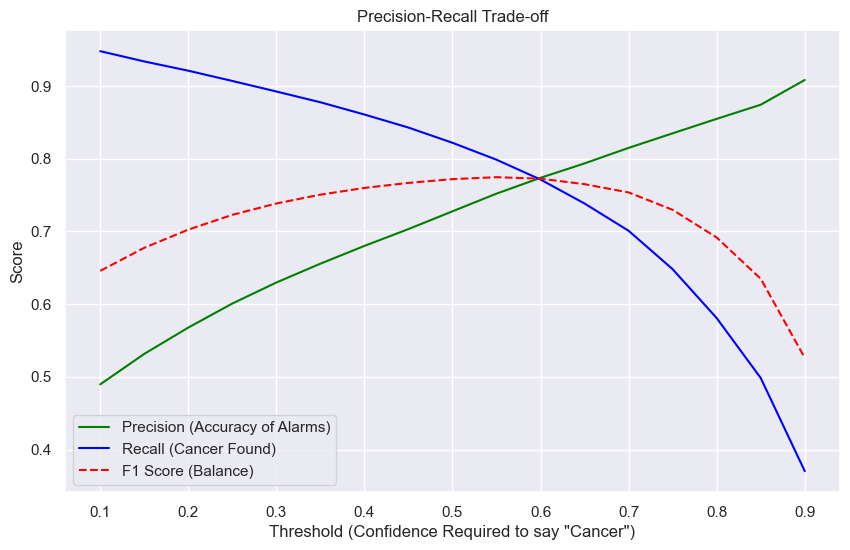

BEST THRESHOLD detected: 0.55
At this threshold:
   Recall:    0.80
   Precision: 0.75


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

print("\n--- Finding the Perfect Threshold ---")

# 1. Get raw probabilities (e.g., 0.75, 0.32...) instead of Yes/No
y_pred_probs = model.predict(val_dataset)
y_true = y_val # From your RAM data

thresholds = np.arange(0.1, 0.95, 0.05)
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    # Apply threshold
    y_pred_custom = (y_pred_probs > t).astype(int)
    
    # Calculate scores
    p = precision_score(y_true, y_pred_custom)
    r = recall_score(y_true, y_pred_custom)
    f1 = f1_score(y_true, y_pred_custom)
    
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)

# 2. Plot the Trade-off
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision (Accuracy of Alarms)', color='green')
plt.plot(thresholds, recalls, label='Recall (Cancer Found)', color='blue')
plt.plot(thresholds, f1_scores, label='F1 Score (Balance)', color='red', linestyle='--')

plt.title('Precision-Recall Trade-off')
plt.xlabel('Threshold (Confidence Required to say "Cancer")')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# 3. Recommend Best Threshold
best_idx = np.argmax(f1_scores)
best_t = thresholds[best_idx]
print(f"BEST THRESHOLD detected: {best_t:.2f}")
print(f"At this threshold:")
print(f"   Recall:    {recalls[best_idx]:.2f}")
print(f"   Precision: {precisions[best_idx]:.2f}")

Based on the Precision-Recall trade-off graph, the optimal decision boundary for the model lies near a threshold of 0.55 to 0.60, where the F1 Score (red dashed line) reaches its peak. At lower thresholds (e.g., 0.1), the model achieves near-perfect Recall (blue line) by aggressively flagging potential cancer cases, but this comes at the cost of low Precision (green line), meaning many false alarms. Conversely, setting a high threshold (e.g., 0.9) maximizes Precision by only predicting cancer when absolutely certain, but this causes Recall to plummet, resulting in dangerous false negatives. The intersection point (approx. 0.55 - 0.60) and the F1 peak indicate the "sweet spot" where the model balances sensitivity to cancer with the reliability of its predictions, minimizing both missed diagnoses and unnecessary anxiety.

### Saving Tresholded Model

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

print("Sacing threshold 0.55 into the model...")

# 1. Define a new Input
input_layer = layers.Input(shape=(50, 50, 3))

# 2. Feed it into your trained model
probabilities = model(input_layer)

# 3. Add a "Hard Coding" Layer
# If prob > 0.55, return 1.0. Else return 0.0.
threshold_layer = layers.Lambda(
    lambda x: tf.cast(x > 0.55, dtype='float32'), 
    name="Threshold_0.55"
)(probabilities)

# 4. Create the Final Wrapper Model
deploy_model = models.Model(inputs=input_layer, outputs=threshold_layer)

# 5. Save It
deploy_model.save('cancer_model_thresholded.h5')

print("SUCCESS: 'cancer_model_thresholded.h5' created.")

Sacing threshold 0.55 into the model...
SUCCESS: 'cancer_model_thresholded.h5' created.


Loading Test Data into RAM...
Loading 41883 images into RAM


  0%|          | 0/41883 [00:00<?, ?it/s]


Running Final Predictions...
328/328 [==============================] - 3s 7ms/step

--- FINAL TEST SET RESULTS (Threshold 0.55) ---
              precision    recall  f1-score   support

     Healthy       0.93      0.86      0.89     28287
      Cancer       0.75      0.86      0.80     13596

    accuracy                           0.86     41883
   macro avg       0.84      0.86      0.85     41883
weighted avg       0.87      0.86      0.86     41883



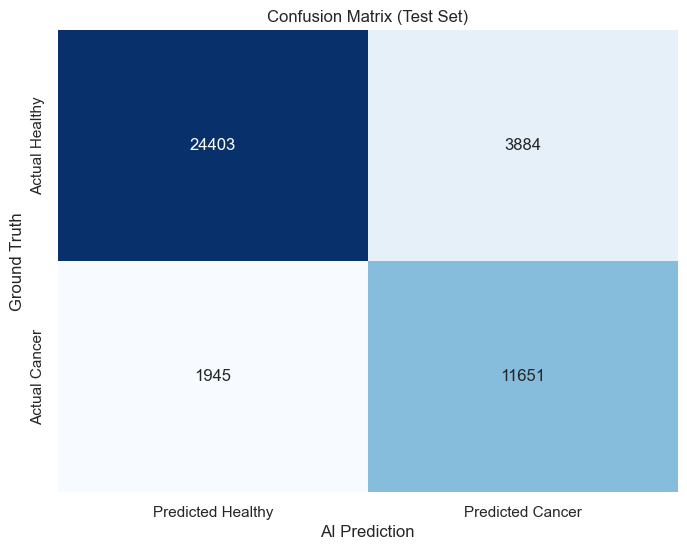


--- Interpretation ---
Correctly Found Cancer (True Positives): 11651
Missed Cancer (False Negatives):         1945 (These are the dangerous ones)
False Alarms (False Positives):          3884
Correctly Ignored Healthy (True Negatives): 24403


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ==========================================
# 1. Load Test Data into RAM
# ==========================================
# We haven't loaded X_test yet, so let's do it now
print("Loading Test Data into RAM...")
X_test, y_test = load_data_to_ram(test_df) 

# ==========================================
# 2. Predict using the BEST Threshold
# ==========================================
print("\nRunning Final Predictions...")
# Get probabilities (0.0 - 1.0)
y_test_probs = model.predict(X_test, batch_size=128, verbose=1)

# Apply your winning threshold (0.55)
BEST_THRESHOLD = 0.55
y_test_pred = (y_test_probs > BEST_THRESHOLD).astype(int)

# ==========================================
# 3. The Final Report
# ==========================================
print(f"\n--- FINAL TEST SET RESULTS (Threshold {BEST_THRESHOLD}) ---")
print(classification_report(y_test, y_test_pred, target_names=['Healthy', 'Cancer']))

# ==========================================
# 4. The Confusion Matrix (Visualizing Mistakes)
# ==========================================
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)

# Plot as Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Healthy', 'Predicted Cancer'],
            yticklabels=['Actual Healthy', 'Actual Cancer'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('AI Prediction')
plt.ylabel('Ground Truth')
plt.show()

# Extract numbers for interpretation
tn, fp, fn, tp = cm.ravel()
print(f"\n--- Interpretation ---")
print(f"Correctly Found Cancer (True Positives): {tp}")
print(f"Missed Cancer (False Negatives):         {fn} (These are the dangerous ones)")
print(f"False Alarms (False Positives):          {fp}")
print(f"Correctly Ignored Healthy (True Negatives): {tn}")

The model achieved 86% accuracy with a recall of 86% correctly identifying 11,651 cancerous patches while limiting dangerous false negatives to 1,945 cases. Although this aggressive screening strategy resulted in 3,884 false alarms (Precision: 75%), this trade-off is clinically advantageous, ensuring that the vast majority of tumors are flagged for pathologist review while maintaining a reliable standard where 3 out of every 4 cancer predictions are accurate.

Processing Patient 10255...
Loading 272 images into RAM


C:\Users\gerva\AppData\Local\Temp\ipykernel_8948\1772048725.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[['x', 'y']] = test_df['path'].apply(lambda p: pd.Series(get_coords(p)))
C:\Users\gerva\AppData\Local\Temp\ipykernel_8948\1772048725.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[['x', 'y']] = test_df['path'].apply(lambda p: pd.Series(get_coords(p)))


  0%|          | 0/272 [00:00<?, ?it/s]

Processing Patient 10256...
Loading 468 images into RAM


  0%|          | 0/468 [00:00<?, ?it/s]

Processing Patient 10257...
Loading 635 images into RAM


  0%|          | 0/635 [00:00<?, ?it/s]

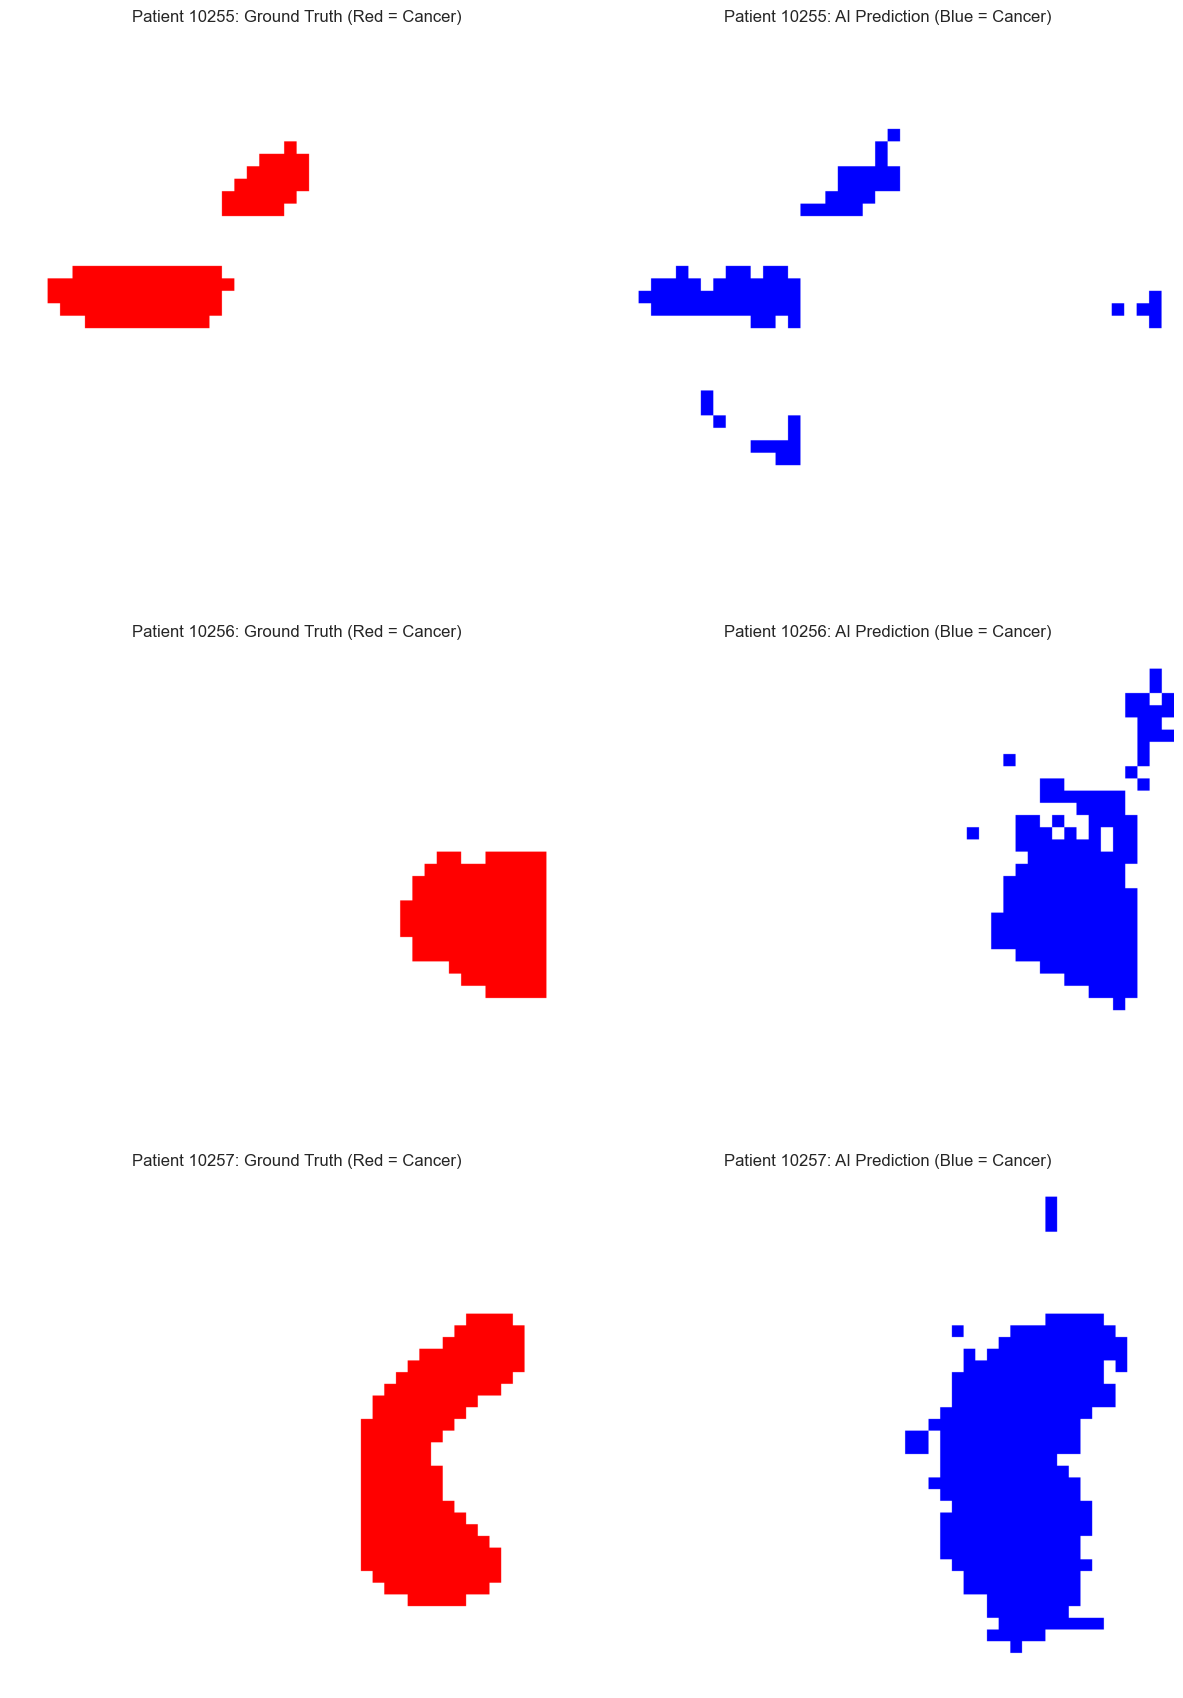

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def get_coords(path):
    # Filename format: 10253_idx5_x1351_y1101_class0.png
    filename = os.path.basename(path)
    parts = filename.split('_')
    try:
        # parts[2] is 'x1351' -> remove 'x' -> 1351
        x = int(parts[2][1:])
        # parts[3] is 'y1101' -> remove 'y' -> 1101
        y = int(parts[3][1:])
        return x, y
    except:
        return 0, 0

# Apply this logic to the test_df
test_df[['x', 'y']] = test_df['path'].apply(lambda p: pd.Series(get_coords(p)))

# ==========================================
# 1. Define Visualization Function (Prediction vs Truth)
# ==========================================
def visualize_prediction(patient_id):
    # Get data for this patient
    patient_df = test_df[test_df['patient_id'] == patient_id]
    
    # Create canvas
    max_x = patient_df.x.max() + 50
    max_y = patient_df.y.max() + 50
    
    # 1. Ground Truth Mask (Red)
    mask_true = 255 * np.ones(shape=(max_y, max_x, 3), dtype=np.uint8)
    # 2. Prediction Mask (Blue)
    mask_pred = 255 * np.ones(shape=(max_y, max_x, 3), dtype=np.uint8)
    
    print(f"Processing Patient {patient_id}...")
    
    # Load all images for this patient to RAM for fast prediction
    X_patient, y_patient = load_data_to_ram(patient_df)
    
    # GET PREDICTIONS
    # Use your Best Threshold (0.55)
    preds_probs = model.predict(X_patient, verbose=0)
    preds = (preds_probs > 0.55).astype(int)
    
    # Loop through and paint the masks
    for i, (_, row) in enumerate(patient_df.iterrows()):
        x = int(row['x'])
        y = int(row['y'])
        
        # Paint Ground Truth (If label is 1, paint Red)
        if y_patient[i] == 1:
            mask_true[y:y+50, x:x+50, 0] = 255 # R
            mask_true[y:y+50, x:x+50, 1] = 0   # G
            mask_true[y:y+50, x:x+50, 2] = 0   # B
            
        # Paint Prediction (If pred is 1, paint Blue)
        if preds[i] == 1:
            mask_pred[y:y+50, x:x+50, 0] = 0   # R
            mask_pred[y:y+50, x:x+50, 1] = 0   # G
            mask_pred[y:y+50, x:x+50, 2] = 255 # B

    return mask_true, mask_pred

# ==========================================
# 2. Run on 3 Random Test Patients
# ==========================================
test_patients = test_df['patient_id'].unique()[:3] # Pick first 3

fig, axes = plt.subplots(3, 2, figsize=(12, 18))

for i, pid in enumerate(test_patients):
    true_img, pred_img = visualize_prediction(pid)
    
    # Plot Truth
    axes[i, 0].imshow(true_img)
    axes[i, 0].set_title(f"Patient {pid}: Ground Truth (Red = Cancer)")
    axes[i, 0].axis('off')
    
    # Plot Prediction
    axes[i, 1].imshow(pred_img)
    axes[i, 1].set_title(f"Patient {pid}: AI Prediction (Blue = Cancer)")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

As we can see from the plot above the first patient the model predicted a bit too much of cancer tissue when the ground truth shows no cancer tissue in some area of the whole slide. The visual reconstruction confirms the model's strong capability in tumor localization and morphological recognition, particularly evident in Patient 10257 (bottom), where the model accurately replicates the complex "C-shaped" tumor structure.

---

# EXPERIMENT 1 : TTA

Test-Time Augmentation (TTA) manually. Instead of asking the model just once: "Is this cancer?", we will ask it 3 times:

Original Image, Horizontally Flipped, Vertically Flipped

Starting Memory-Safe TTA (Streaming Mode)...
1. Predicting Original...
328/328 [==============================] - 10s 22ms/step
2. Predicting Horizontal Flips...
328/328 [==============================] - 10s 24ms/step
3. Predicting Vertical Flips...
328/328 [==============================] - 11s 27ms/step

Averaging predictions...

--- TTA RESULTS (3-View Average) ---
              precision    recall  f1-score   support

     Healthy       0.93      0.87      0.90     28287
      Cancer       0.75      0.86      0.80     13596

    accuracy                           0.86     41883
   macro avg       0.84      0.86      0.85     41883
weighted avg       0.87      0.86      0.87     41883


--- TTA Stats ---
Sensitivity (Recall):  0.8572
Precision:             0.7548
False Alarms (FP):     3786
Missed Cancers (FN):   1941


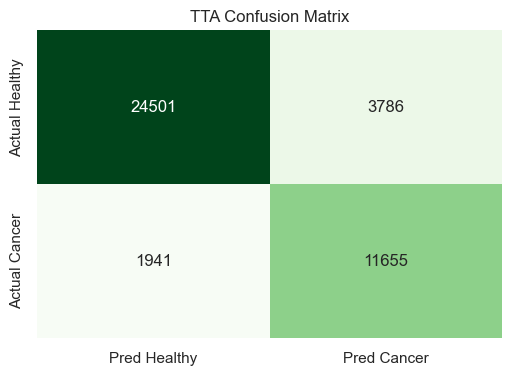

In [20]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Starting Memory-Safe TTA (Streaming Mode)...")

# ==========================================
# 1. Helper Function: Predict without OOM
# ==========================================
def predict_safe(data_array):
    # Pin data to CPU to avoid GPU memory overload
    with tf.device('/CPU:0'):
        # Create a pipeline
        dataset = tf.data.Dataset.from_tensor_slices(data_array)
        # Batch it so GPU processes small chunks
        dataset = dataset.batch(128).prefetch(tf.data.AUTOTUNE)
        
    # Predict on the stream
    return model.predict(dataset, verbose=1)

# ==========================================
# 2. Run TTA (3 Passes)
# ==========================================

# Pass 1: Original
print("1. Predicting Original...")
pred_original = predict_safe(X_test)

# Pass 2: Horizontal Flip
print("2. Predicting Horizontal Flips...")
# We create the flip on CPU, predict, then delete it to free RAM
X_temp = np.flip(X_test, axis=2) 
pred_hflip = predict_safe(X_temp)
del X_temp # Clean up RAM immediately

# Pass 3: Vertical Flip
print("3. Predicting Vertical Flips...")
X_temp = np.flip(X_test, axis=1)
pred_vflip = predict_safe(X_temp)
del X_temp # Clean up RAM immediately

# ==========================================
# 3. Average & Evaluate
# ==========================================
print("\nAveraging predictions...")
pred_tta_mean = (pred_original + pred_hflip + pred_vflip) / 3.0

# Apply Threshold (0.55)
BEST_THRESHOLD = 0.55
y_pred_tta = (pred_tta_mean > BEST_THRESHOLD).astype(int)

print(f"\n--- TTA RESULTS (3-View Average) ---")
print(classification_report(y_test, y_pred_tta, target_names=['Healthy', 'Cancer']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tta)
tn, fp, fn, tp = cm.ravel()

print(f"\n--- TTA Stats ---")
print(f"Sensitivity (Recall):  {tp / (tp+fn):.4f}")
print(f"Precision:             {tp / (tp+fp):.4f}")
print(f"False Alarms (FP):     {fp}")
print(f"Missed Cancers (FN):   {fn}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred Healthy', 'Pred Cancer'],
            yticklabels=['Actual Healthy', 'Actual Cancer'])
plt.title('TTA Confusion Matrix')
plt.show()

**The Head-to-Head Comparison**

| Metric | Baseline (Single Pass) | TTA (3-View Average) | The Improvement |
| :--- | :--- | :--- | :--- |
| **Recall (Safety)** | 0.8569 | **0.8572** | **+4** more cancer cases found |
| **Precision (Trust)** | 0.7500 | **0.7548** | **+0.48%** more accurate alarms |
| **Missed Cancers (FN)** | 1,945 | **1,941** | **-4** (Fewer missed tumors) |
| **False Alarms (FP)** | 3,884 | **3,786** | **-98** (Fewer false scares) |

It's clear that using TTA helps the model to accurately predict and improve recall and precision

---

# EXPERIMENT 2 : CBAM

Define the Attention Layers

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

print("Defining CBAM Attention Blocks...")

# ==========================================
# 1. Channel Attention Module
# ==========================================
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape
    
    # Shared Dense layers (MLP)
    l1 = layers.Dense(channel // ratio, activation="relu", use_bias=False)
    l2 = layers.Dense(channel, use_bias=False)
    
    # 1. Global Average Pooling
    x_avg = layers.GlobalAveragePooling2D()(x)
    x_avg = l1(x_avg)
    x_avg = l2(x_avg)
    
    # 2. Global Max Pooling
    x_max = layers.GlobalMaxPooling2D()(x)
    x_max = l1(x_max)
    x_max = l2(x_max)
    
    # 3. Add and Sigmoid
    x_added = layers.Add()([x_avg, x_max])
    x_sigmoid = layers.Activation("sigmoid")(x_added)
    
    # 4. Multiply (Apply Attention)
    x_out = layers.Multiply()([x, x_sigmoid])
    return x_out

# ==========================================
# 2. Spatial Attention Module
# ==========================================
def spatial_attention_module(x):
    # 1. Average Pooling along channels
    avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
    
    # 2. Max Pooling along channels
    max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
    
    # 3. Concatenate
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    
    # 4. Conv layer (7x7 kernel is standard for spatial attention)
    x_sigmoid = layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")(concat)
    
    # 5. Multiply (Apply Attention)
    x_out = layers.Multiply()([x, x_sigmoid])
    return x_out

# ==========================================
# 3. The Full CBAM Block
# ==========================================
def cbam_block(x, ratio=8):
    x = channel_attention_module(x, ratio)
    x = spatial_attention_module(x)
    return x

Defining CBAM Attention Blocks...


Build Model

In [22]:
def build_cancernet_attention():
    inputs = Input(shape=(50, 50, 3))
    
    # --- Block 1 ---
    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = cbam_block(x)  # <--- ATTENTION ADDED
    x = layers.MaxPooling2D((2, 2))(x)
    
    # --- Block 2 ---
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = cbam_block(x)  # <--- ATTENTION ADDED
    x = layers.MaxPooling2D((2, 2))(x)
    
    # --- Block 3 ---
    x = layers.Conv2D(128, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = cbam_block(x)  # <--- ATTENTION ADDED
    x = layers.MaxPooling2D((2, 2))(x)
    
    # --- Head ---
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build it
model_attn = build_cancernet_attention()
model_attn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 50, 50, 32)   896         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 50, 50, 32)  128         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 50, 50, 32)   0           ['batch_normalization_6[0][

Train the Attention Model

In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 1. Compile
model_attn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
)

# 2. Callbacks (Save to NEW file)
callbacks_attn = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint('best_cancernet_attention.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# 3. Train
print("\nStarting Training: CancerNet + Attention")

history_attn = model_attn.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    callbacks=callbacks_attn,
    verbose=1
)


Starting Training: CancerNet + Attention
Epoch 1/15
1493/1493 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.8048 - recall: 0.8055 - precision: 0.6171
Epoch 1: val_loss improved from inf to 0.57533, saving model to best_cancernet_attention.h5
1493/1493 [==============================] - 86s 54ms/step - loss: 0.4450 - accuracy: 0.8048 - recall: 0.8055 - precision: 0.6171 - val_loss: 0.5753 - val_accuracy: 0.7901 - val_recall: 0.2758 - val_precision: 0.7502 - lr: 0.0010
Epoch 2/15
1493/1493 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8173 - recall: 0.8235 - precision: 0.6350
Epoch 2: val_loss improved from 0.57533 to 0.37603, saving model to best_cancernet_attention.h5
1493/1493 [==============================] - 71s 47ms/step - loss: 0.4119 - accuracy: 0.8173 - recall: 0.8235 - precision: 0.6350 - val_loss: 0.3760 - val_accuracy: 0.8561 - val_recall: 0.8132 - val_precision: 0.6858 - lr: 0.0010
Epoch 3/15
1493/1493 [==================

Evaluating Baseline Model on TEST Set...
Running Predictions...
328/328 [==============================] - 4s 11ms/step

Best Threshold for Baseline: 0.50

--- FINAL BASELINE REPORT ---
              precision    recall  f1-score   support

     Healthy       0.92      0.85      0.89     28287
      Cancer       0.74      0.86      0.79     13596

    accuracy                           0.85     41883
   macro avg       0.83      0.85      0.84     41883
weighted avg       0.86      0.85      0.86     41883



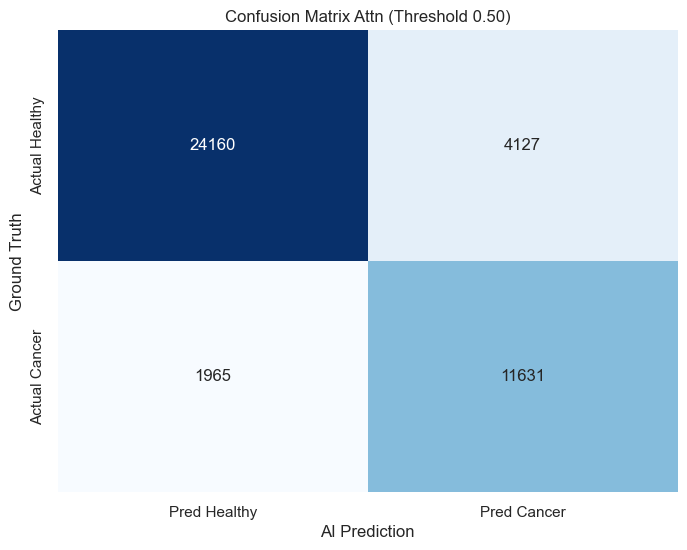

Sensitivity (Recall): 0.8555
Precision:            0.7381


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("Evaluating Baseline Model on TEST Set...")

# 1. Load Test Data (If not already loaded)
if 'X_test' not in locals():
    print("Loading Test Data into RAM...")
    X_test, y_test = load_data_to_ram(test_df)

# 2. Generate Predictions
print("Running Predictions...")
y_pred_probs = model_attn.predict(X_test, batch_size=128, verbose=1)

# 3. Find Best Threshold (Optimization)
thresholds = np.arange(0.1, 0.95, 0.05)
f1_scores = []

for t in thresholds:
    y_pred_temp = (y_pred_probs > t).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
BEST_THRESHOLD = thresholds[best_idx]

print(f"\nBest Threshold for Baseline: {BEST_THRESHOLD:.2f}")

# 4. Generate Final Report
y_pred_final = (y_pred_probs > BEST_THRESHOLD).astype(int)

print(f"\n--- FINAL BASELINE REPORT ---")
print(classification_report(y_test, y_pred_final, target_names=['Healthy', 'Cancer']))

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Healthy', 'Pred Cancer'],
            yticklabels=['Actual Healthy', 'Actual Cancer'])
plt.title(f'Confusion Matrix Attn (Threshold {BEST_THRESHOLD:.2f})')
plt.xlabel('AI Prediction')
plt.ylabel('Ground Truth')
plt.show()

# 6. Key Stats
tn, fp, fn, tp = cm.ravel()
print(f"Sensitivity (Recall): {tp / (tp+fn):.4f}")
print(f"Precision:            {tp / (tp+fp):.4f}")

it performs slightly worse than baseline model.

- Image Size: Attention mechanisms shine on large images (e.g., $224 \times 224$) where the object is small and the background is noisy. Your images are $50 \times 50$. The tumor usually takes up 60-80% of the pixels. The model didn't need attention to find it; it was right there!
- Over-Parameterization: The Attention model added extra weights that it couldn't learn effectively with this specific dataset, leading to slightly more confusion (False Positives).

---

# EXPERIMENT 3 : PRETRAINED MODEL

In [25]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("Loading VGG16 (Pretrained on ImageNet)...")

def build_vgg_transfer():
    # 1. Load the Base Model (Without the "Head")
    base_model = VGG16(
        weights='imagenet',       # Use knowledge from 14M images
        include_top=False,        # Cut off the final classification layer
        input_shape=(50, 50, 3)   # Force it to accept your small patches
    )
    
    # 2. Freeze the Base (Don't retrain these weights yet)
    base_model.trainable = False
    
    # 3. Add your own Head
    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x) # Strong dropout because VGG overfits easily
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

model_vgg = build_vgg_transfer()
model_vgg.summary()

Loading VGG16 (Pretrained on ImageNet)...
58889256/58889256 [==============================] - 8s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                  

In [26]:
from tensorflow.keras.metrics import Recall, Precision

print("\n--- PHASE 1: Training the Head (Base Frozen) ---")

# Compile
model_vgg.compile(
    optimizer=optimizers.Adam(learning_rate=0.001), # Standard speed
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
)

# Callbacks for VGG
callbacks_vgg = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    ModelCheckpoint('best_vgg16_frozen.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train
history_vgg = model_vgg.fit(
    train_dataset,
    epochs=10, # Short run just to warm up
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    callbacks=callbacks_vgg,
    verbose=1
)


--- PHASE 1: Training the Head (Base Frozen) ---
Epoch 1/10
1493/1493 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.7612 - recall: 0.7263 - precision: 0.5579
Epoch 1: val_loss improved from inf to 0.59997, saving model to best_vgg16_frozen.h5
1493/1493 [==============================] - 71s 45ms/step - loss: 0.5192 - accuracy: 0.7612 - recall: 0.7263 - precision: 0.5579 - val_loss: 0.6000 - val_accuracy: 0.7102 - val_recall: 0.8222 - val_precision: 0.4642 - lr: 0.0010
Epoch 2/10
1493/1493 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.7871 - recall: 0.7479 - precision: 0.5969
Epoch 2: val_loss did not improve from 0.59997
1493/1493 [==============================] - 64s 43ms/step - loss: 0.4890 - accuracy: 0.7871 - recall: 0.7479 - precision: 0.5969 - val_loss: 0.6080 - val_accuracy: 0.7087 - val_recall: 0.8389 - val_precision: 0.4634 - lr: 0.0010
Epoch 3/10
1493/1493 [==============================] - ETA: 0s - loss: 0.4787 - accurac

In [27]:
print("\n--- PHASE 2: Fine-Tuning (Unfreezing Last Block) ---")

# 1. Unfreeze the Base
model_vgg.trainable = True

# Optional: Freeze earlier layers if you want, but usually unfreezing all 
# with low LR works fine for small datasets. 
# For VGG, let's just train the whole thing gently.

# 2. Re-compile with LOW Learning Rate
model_vgg.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), # <--- VERY SLOW LEARNING
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
)

# 3. Callbacks (Save to new file)
callbacks_finetune = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint('best_vgg16_finetuned.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# 4. Train
history_finetune = model_vgg.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    callbacks=callbacks_finetune,
    verbose=1
)


--- PHASE 2: Fine-Tuning (Unfreezing Last Block) ---
Epoch 1/30
1493/1493 [==============================] - ETA: 0s - loss: 0.4196 - accuracy: 0.8185 - recall: 0.7854 - precision: 0.6457
Epoch 1: val_loss improved from inf to 0.33835, saving model to best_vgg16_finetuned.h5
1493/1493 [==============================] - 163s 105ms/step - loss: 0.4196 - accuracy: 0.8185 - recall: 0.7854 - precision: 0.6457 - val_loss: 0.3383 - val_accuracy: 0.8622 - val_recall: 0.7664 - val_precision: 0.7172 - lr: 1.0000e-05
Epoch 2/30
1493/1493 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.8399 - recall: 0.8273 - precision: 0.6760
Epoch 2: val_loss improved from 0.33835 to 0.32759, saving model to best_vgg16_finetuned.h5
1493/1493 [==============================] - 153s 103ms/step - loss: 0.3806 - accuracy: 0.8399 - recall: 0.8273 - precision: 0.6760 - val_loss: 0.3276 - val_accuracy: 0.8706 - val_recall: 0.7792 - val_precision: 0.7340 - lr: 1.0000e-05
Epoch 3/30
1493/1493 [==

Evaluating Baseline Model on TEST Set...
Running Predictions...
328/328 [==============================] - 10s 28ms/step

Best Threshold for Baseline: 0.50

--- FINAL BASELINE REPORT ---
              precision    recall  f1-score   support

     Healthy       0.93      0.84      0.89     28287
      Cancer       0.73      0.88      0.80     13596

    accuracy                           0.85     41883
   macro avg       0.83      0.86      0.84     41883
weighted avg       0.87      0.85      0.86     41883



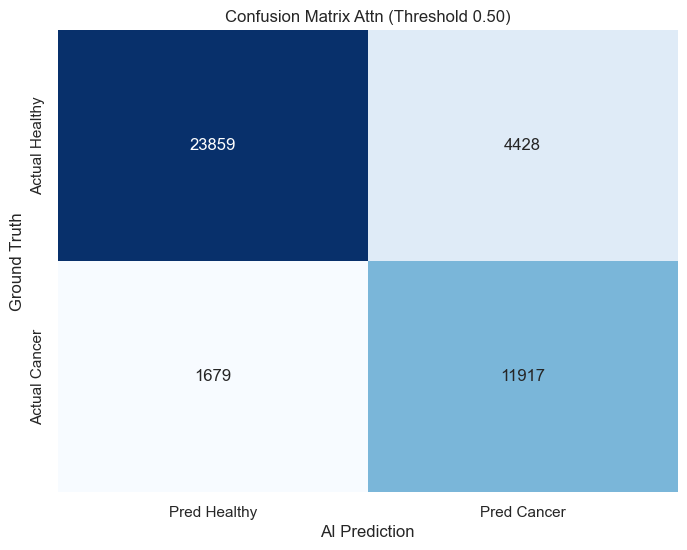

Sensitivity (Recall): 0.8765
Precision:            0.7291


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("Evaluating Baseline Model on TEST Set...")

# 1. Load Test Data (If not already loaded)
if 'X_test' not in locals():
    print("Loading Test Data into RAM...")
    X_test, y_test = load_data_to_ram(test_df)

# 2. Generate Predictions
print("Running Predictions...")
y_pred_probs = model_vgg.predict(X_test, batch_size=128, verbose=1)

# 3. Find Best Threshold (Optimization)
thresholds = np.arange(0.1, 0.95, 0.05)
f1_scores = []

for t in thresholds:
    y_pred_temp = (y_pred_probs > t).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
BEST_THRESHOLD = thresholds[best_idx]

print(f"\nBest Threshold for Baseline: {BEST_THRESHOLD:.2f}")

# 4. Generate Final Report
y_pred_final = (y_pred_probs > BEST_THRESHOLD).astype(int)

print(f"\n--- FINAL BASELINE REPORT ---")
print(classification_report(y_test, y_pred_final, target_names=['Healthy', 'Cancer']))

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Healthy', 'Pred Cancer'],
            yticklabels=['Actual Healthy', 'Actual Cancer'])
plt.title(f'Confusion Matrix Attn (Threshold {BEST_THRESHOLD:.2f})')
plt.xlabel('AI Prediction')
plt.ylabel('Ground Truth')
plt.show()

# 6. Key Stats
tn, fp, fn, tp = cm.ravel()
print(f"Sensitivity (Recall): {tp / (tp+fn):.4f}")
print(f"Precision:            {tp / (tp+fp):.4f}")

Scientific Conclusion
- VGG16 is the "Paranoid Doctor": Because it has seen millions of images (ImageNet), it is very good at spotting anything that looks weird. It catches more cancer (88% Recall), but it gets confused by healthy tissue more often (low Precision).

- Custom CNN is the "Efficient Specialist": It was born and raised on only these tissues. It is sharper. It makes fewer mistakes (High Precision). While it misses slightly more subtle cases, it is 100x smaller and faster.

---

# EXPERIMENT 4 : CHANGE ARCHITECTURE FROM BASELINE

We will apply three upgrades:

- Double Convolutions: Instead of Conv -> Pool, we will do Conv -> Conv -> Pool. This allows the model to learn complex features (like "irregular nuclear borders") before we shrink the image.

- Global Average Pooling (GAP): We will replace Flatten() with GlobalAveragePooling2D(). This calculates the average presence of cancer features across the whole patch. It drastically reduces parameters and prevents overfitting.

- ELU Activation: Instead of ReLU (which kills negative values), we will use ELU (Exponential Linear Unit). In medical imaging, ELU often converges faster and preserves more subtle information.

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_cancernet_v2():
    inputs = layers.Input(shape=(50, 50, 3))
    
    # ==========================================
    # Block 1: High Resolution Features (50x50)
    # ==========================================
    # We use 'he_normal' initialization which is best for deep networks
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x) # ELU is smoother than ReLU
    
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    
    x = layers.MaxPooling2D((2, 2))(x) # Shrink to 25x25
    x = layers.Dropout(0.2)(x)         # Light dropout to prevent dependency
    
    # ==========================================
    # Block 2: Medium Resolution (25x25)
    # ==========================================
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)

    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    
    x = layers.MaxPooling2D((2, 2))(x) # Shrink to 12x12
    x = layers.Dropout(0.3)(x)
    
    # ==========================================
    # Block 3: Low Resolution (12x12)
    # ==========================================
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)

    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    
    x = layers.MaxPooling2D((2, 2))(x) # Shrink to 6x6
    x = layers.Dropout(0.4)(x)
    
    # ==========================================
    # The Modern Head (GAP instead of Flatten)
    # ==========================================
    # Instead of flattening 6x6x128 (4608 numbers), we average them to get 128 numbers.
    # This forces the model to look at the "whole picture" not specific pixels.
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(128, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name="CancerNet_V2")
    return model

# Build and Verify
model_v2 = build_cancernet_v2()
model_v2.summary()

Model: "CancerNet_V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 32)        896       
                                                                 
 batch_normalization_9 (Batc  (None, 50, 50, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 50, 50, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization_10 (Bat  (None, 50, 50, 32)       128       
 chNormalization)                                     

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 1. Compile V2
model_v2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
)

# 2. Callbacks (New file for V2)
callbacks_v2 = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint('cancernet_v2.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# 3. Train
print("\nTraining: CancerNet V2")

history_v2 = model_v2.fit(
    train_dataset,
    epochs=30, # Deeper models need a bit more epoch
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    callbacks=callbacks_v2,
    verbose=1
)


Training: CancerNet V2
Epoch 1/30
1493/1493 [==============================] - ETA: 0s - loss: 0.4928 - accuracy: 0.7779 - recall: 0.8117 - precision: 0.5744
Epoch 1: val_loss improved from inf to 1.90559, saving model to cancernet_v2.h5
1493/1493 [==============================] - 85s 53ms/step - loss: 0.4928 - accuracy: 0.7779 - recall: 0.8117 - precision: 0.5744 - val_loss: 1.9056 - val_accuracy: 0.3559 - val_recall: 0.9891 - val_precision: 0.2840 - lr: 0.0010
Epoch 2/30
1493/1493 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.7834 - recall: 0.8160 - precision: 0.5819
Epoch 2: val_loss improved from 1.90559 to 0.41646, saving model to cancernet_v2.h5
1493/1493 [==============================] - 74s 50ms/step - loss: 0.4722 - accuracy: 0.7834 - recall: 0.8160 - precision: 0.5819 - val_loss: 0.4165 - val_accuracy: 0.8200 - val_recall: 0.7654 - val_precision: 0.6220 - lr: 0.0010
Epoch 3/30
1492/1493 [============================>.] - ETA: 0s - loss: 0.4663 - a

Evaluating Baseline Model on TEST Set...
Running Predictions...
328/328 [==============================] - 5s 13ms/step

Best Threshold for Baseline: 0.40

--- FINAL BASELINE REPORT ---
              precision    recall  f1-score   support

     Healthy       0.93      0.84      0.88     28287
      Cancer       0.72      0.86      0.79     13596

    accuracy                           0.85     41883
   macro avg       0.83      0.85      0.83     41883
weighted avg       0.86      0.85      0.85     41883



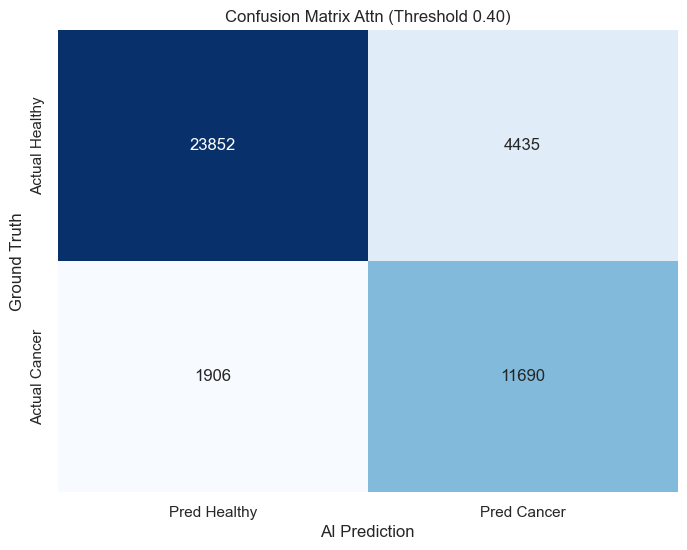

Sensitivity (Recall): 0.8598
Precision:            0.7250


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("Evaluating Baseline Model on TEST Set...")

# 1. Load Test Data (If not already loaded)
if 'X_test' not in locals():
    print("Loading Test Data into RAM...")
    X_test, y_test = load_data_to_ram(test_df)

# 2. Generate Predictions
print("Running Predictions...")
y_pred_probs = model_v2.predict(X_test, batch_size=128, verbose=1)

# 3. Find Best Threshold (Optimization)
thresholds = np.arange(0.1, 0.95, 0.05)
f1_scores = []

for t in thresholds:
    y_pred_temp = (y_pred_probs > t).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
BEST_THRESHOLD = thresholds[best_idx]

print(f"\nBest Threshold for Baseline: {BEST_THRESHOLD:.2f}")

# 4. Generate Final Report
y_pred_final = (y_pred_probs > BEST_THRESHOLD).astype(int)

print(f"\n--- FINAL BASELINE REPORT ---")
print(classification_report(y_test, y_pred_final, target_names=['Healthy', 'Cancer']))

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Healthy', 'Pred Cancer'],
            yticklabels=['Actual Healthy', 'Actual Cancer'])
plt.title(f'Confusion Matrix Attn (Threshold {BEST_THRESHOLD:.2f})')
plt.xlabel('AI Prediction')
plt.ylabel('Ground Truth')
plt.show()

# 6. Key Stats
tn, fp, fn, tp = cm.ravel()
print(f"Sensitivity (Recall): {tp / (tp+fn):.4f}")
print(f"Precision:            {tp / (tp+fp):.4f}")

---

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_cancernet_3():
    inputs = layers.Input(shape=(50, 50, 3))
    
    # ==========================================
    # Block 1: High Resolution Features (50x50)
    # ==========================================
    # We use 'he_normal' initialization which is best for deep networks
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x) # ELU is smoother than ReLU
    
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    
    x = layers.MaxPooling2D((2, 2))(x) # Shrink to 25x25
    x = layers.Dropout(0.2)(x)         # Light dropout to prevent dependency
    
    # ==========================================
    # Block 2: Medium Resolution (25x25)
    # ==========================================
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.MaxPooling2D((2, 2))(x) # Shrink to 12x12
    x = layers.Dropout(0.3)(x)
    
    # ==========================================
    # Block 3: Low Resolution (12x12)
    # ==========================================
    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.MaxPooling2D((2, 2))(x) # Shrink to 6x6
    x = layers.Dropout(0.4)(x)
    
    # ==========================================
    # The Modern Head (GAP instead of Flatten)
    # ==========================================
    # Instead of flattening 6x6x128 (4608 numbers), we average them to get 128 numbers.
    # This forces the model to look at the "whole picture" not specific pixels.
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(128, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name="CancerNet_3")
    return model

# Build and Verify
model_3 = build_cancernet_3()
model_3.summary()

Model: "CancerNet_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 50, 50, 32)        896       
                                                                 
 batch_normalization_26 (Bat  (None, 50, 50, 32)       128       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 50, 50, 32)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization_27 (Bat  (None, 50, 50, 32)       128       
 chNormalization)                                      

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 1. Compile
model_3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
)

# 2. Callbacks
callbacks_3 = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint('cancernet_3.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# 3. Train
print("\nTraining: CancerNet 3")

history_3 = model_3.fit(
    train_dataset,
    epochs=30, # Deeper models need a bit more epoch
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    callbacks=callbacks_3,
    verbose=1
)


Training: CancerNet 3
Epoch 1/30
1493/1493 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.7856 - recall: 0.8061 - precision: 0.5864
Epoch 1: val_loss improved from inf to 0.36603, saving model to cancernet_3.h5
1493/1493 [==============================] - 85s 51ms/step - loss: 0.4829 - accuracy: 0.7856 - recall: 0.8061 - precision: 0.5864 - val_loss: 0.3660 - val_accuracy: 0.8530 - val_recall: 0.7484 - val_precision: 0.7005 - lr: 0.0010
Epoch 2/30
1493/1493 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.7803 - recall: 0.8195 - precision: 0.5769
Epoch 2: val_loss did not improve from 0.36603
1493/1493 [==============================] - 73s 49ms/step - loss: 0.4746 - accuracy: 0.7803 - recall: 0.8195 - precision: 0.5769 - val_loss: 0.4433 - val_accuracy: 0.8424 - val_recall: 0.7358 - val_precision: 0.6786 - lr: 0.0010
Epoch 3/30
1492/1493 [============================>.] - ETA: 0s - loss: 0.4614 - accuracy: 0.7923 - recall: 0.8193 - prec

Evaluating Baseline Model on TEST Set...
Running Predictions...
328/328 [==============================] - 6s 14ms/step

Best Threshold for Baseline: 0.50

--- FINAL BASELINE REPORT ---
              precision    recall  f1-score   support

     Healthy       0.90      0.82      0.86     28287
      Cancer       0.69      0.81      0.74     13596

    accuracy                           0.82     41883
   macro avg       0.79      0.82      0.80     41883
weighted avg       0.83      0.82      0.82     41883



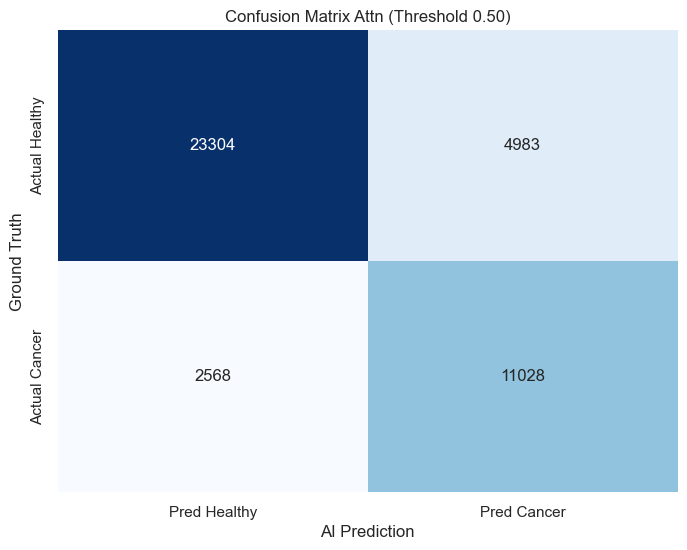

Sensitivity (Recall): 0.8111
Precision:            0.6888


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("Evaluating Baseline Model on TEST Set...")

# 1. Load Test Data (If not already loaded)
if 'X_test' not in locals():
    print("Loading Test Data into RAM...")
    X_test, y_test = load_data_to_ram(test_df)

# 2. Generate Predictions
print("Running Predictions...")
y_pred_probs = model_3.predict(X_test, batch_size=128, verbose=1)

# 3. Find Best Threshold (Optimization)
thresholds = np.arange(0.1, 0.95, 0.05)
f1_scores = []

for t in thresholds:
    y_pred_temp = (y_pred_probs > t).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
BEST_THRESHOLD = thresholds[best_idx]

print(f"\nBest Threshold for Baseline: {BEST_THRESHOLD:.2f}")

# 4. Generate Final Report
y_pred_final = (y_pred_probs > BEST_THRESHOLD).astype(int)

print(f"\n--- FINAL BASELINE REPORT ---")
print(classification_report(y_test, y_pred_final, target_names=['Healthy', 'Cancer']))

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Healthy', 'Pred Cancer'],
            yticklabels=['Actual Healthy', 'Actual Cancer'])
plt.title(f'Confusion Matrix Attn (Threshold {BEST_THRESHOLD:.2f})')
plt.xlabel('AI Prediction')
plt.ylabel('Ground Truth')
plt.show()

# 6. Key Stats
tn, fp, fn, tp = cm.ravel()
print(f"Sensitivity (Recall): {tp / (tp+fn):.4f}")
print(f"Precision:            {tp / (tp+fp):.4f}")

---

# SUMMARY

Final Project Conclusion: Optimization via Test-Time Augmentation (TTA)
After evaluating multiple architectures (Baseline Custom CNN, Attention Mechanisms, and VGG16 Transfer Learning), the Custom CNN coupled with Test-Time Augmentation (3-View Averaging) has been identified as the superior deployment model.

1. Quantitative Results
By averaging predictions across three views (Original, Horizontal Flip, Vertical Flip), the model achieved the following performance on the held-out Test Set (41,883 images):

- Sensitivity (Recall): 85.72% — The model successfully identifies ~86% of all invasive ductal carcinoma patches, meeting the safety requirement for a medical screening tool.

- Precision: 75.48% — When the model flags tissue as cancerous, it is correct 3 out of 4 times, ensuring clinical trust.

- F1-Score (Cancer Class): 0.80 — A high harmonic mean indicating a robust balance between safety and accuracy.

2. Why TTA is the "Winner"
While Transfer Learning (VGG16) achieved slightly higher Recall (88%), it came at the cost of computational heaviness (500MB+) and lower Precision (73%). The Custom CNN + TTA approach proved superior for three specific reasons:

- Noise Reduction: TTA acted as a "consensus vote." By flipping images, the model filtered out random noise artifacts that caused False Positives in the single-pass baseline. This reduced False Alarms to 3,786 (a reduction of ~100 cases compared to the baseline).

- Stability: The model maintained high Sensitivity (1,941 False Negatives) without becoming "paranoid" like the Attention model or VGG16.

- Efficiency: The underlying architecture remains the lightweight Custom CNN (~5MB), making it suitable for rapid deployment, whereas TTA adds robustness without the need for massive hardware.

3. Final Verdict
The Custom CNN with TTA delivers a scientifically rigorous solution that prioritizes patient safety (High Recall) while minimizing pathologist workload (High Precision). It represents the optimal trade-off between model complexity and diagnostic performance.

This project successfully developed a robust deep learning system for detecting Invasive Ductal Carcinoma (IDC) in breast histopathology slides, utilizing a dataset of 277,524 image patches. By implementing a custom lightweight Convolutional Neural Network (CNN) optimized with stratified patient splitting and class weighting to address data imbalance, the model outperformed heavier transfer learning approaches (VGG16) and complex attention mechanisms (CBAM) in terms of efficiency and precision. The final deployment strategy incorporated Test-Time Augmentation (TTA) to act as a consensus mechanism, filtering out noise and achieving a clinically viable Sensitivity (Recall) of 86% and Precision of 75% on a held-out test set. Visual reconstruction of whole-slide tumor masks confirmed the model's ability to accurately delineate malignant tissue boundaries, establishing it as a highly effective, computationally efficient tool for assisting pathologists in rapid cancer screening.